# Investigation of Station Data from Bay Area Bike Share Published Data

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import scipy
import math
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime

import seaborn as sns
# sns.set()
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 10

# Load Trip Data

In [3]:
print('[%s] Loading Trip Data...' % datetime.datetime.now().time())

trips_df = pd.DataFrame()
trip_data_file = '../clean_data/bayareabikeshare/trip_data_extended_cleaned.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(trip_data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(trip_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['start_date', 'end_date']):
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

trips_df = pd.concat(chunks)
trips_df.user_type = trips_df.user_type.astype('category')

print('[%s] Complete!' % datetime.datetime.now().time())


[13:15:26.437494] Loading Trip Data...
		[13:15:27.489164] finished chunk 1 of 100
		[13:15:28.357507] finished chunk 10 of 100
		[13:15:29.288371] finished chunk 20 of 100
		[13:15:30.212911] finished chunk 30 of 100
		[13:15:31.268752] finished chunk 40 of 100
		[13:15:32.210541] finished chunk 50 of 100
		[13:15:33.165280] finished chunk 60 of 100
		[13:15:34.065882] finished chunk 70 of 100
		[13:15:35.116906] finished chunk 80 of 100
		[13:15:36.177459] finished chunk 90 of 100
		[13:15:37.109318] finished chunk 100 of 100
[13:15:37.967312] Complete!


In [4]:
trips_df.head(5)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,end_zip,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN


## Utility Functions

In [5]:
def zip_to_landmark(zip_code):
    ''' Return zipcode for given landmark'''
    if zip_code == 94107:
        return 'San Francisco'
    if zip_code == 94063:
        return 'Redwood City'
    if zip_code == 94301:
        return 'Palo Alto'
    if zip_code == 94041:
        return 'Mountain View'
    if zip_code == 95113:
        return 'San Jose'
    return False

In [6]:
day_labels = ['MON','TUE','WED','THU','FRI','SAT','SUN']
day_labels_full = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
month_labels = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

ordered_zipcodes = [94107, 95113, 94041, 94301, 94063]

# Cleanup
<p>Prune to only Commuter Trips, in all regions</p>

<ul>
    <li>user_type : subscriber</li>
    <li>start and end times are between 7am and 10am, or between 4pm and 7pm</li>
</ul>

In [7]:
subscriber_trips_df = trips_df[trips_df.user_type == 'Subscriber']

morning_commuter_trips_df = subscriber_trips_df[(subscriber_trips_df.start_date.dt.hour >= 7) & (subscriber_trips_df.start_date.dt.hour < 10) & (subscriber_trips_df.start_date.dt.dayofweek < 5)]
evening_commuter_trips_df = subscriber_trips_df[(subscriber_trips_df.start_date.dt.hour >= 16) & (subscriber_trips_df.start_date.dt.hour < 19) & (subscriber_trips_df.start_date.dt.dayofweek < 5)]

commuter_trips_df = pd.concat([morning_commuter_trips_df, evening_commuter_trips_df])
commuter_trips_df.reset_index(inplace=True, drop=True)
commuter_trips_df.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,end_zip,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN


In [8]:
commuter_trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548223 entries, 0 to 548222
Data columns (total 23 columns):
trip_id               548223 non-null int64
duration              548223 non-null int64
start_date            548223 non-null datetime64[ns]
start_station_name    548223 non-null object
start_terminal        548223 non-null int64
end_date              548223 non-null datetime64[ns]
end_station_name      548223 non-null object
end_terminal          548223 non-null int64
bike_id               548223 non-null int64
user_type             548223 non-null category
user_zip              548223 non-null int64
duration_minutes      548223 non-null float64
start_zip             548223 non-null int64
end_zip               548223 non-null int64
max_temp              548197 non-null float64
mean_temp             548197 non-null float64
min_temp              548197 non-null float64
max_wind              548223 non-null float64
mean_wind             548223 non-null float64
max_gust          

## Analysis 1 - Explore Station Usage
<p>Find Most Start and End Terminals</p>
<p></p>
<p></p>

In [9]:
popular_stations_df = pd.DataFrame()

# count trips starting at each terminal 
popular_stations_df = commuter_trips_df.groupby('start_terminal')['trip_id'].count().to_frame()
popular_stations_df.columns = ['start_count']

# calculate share of all trip starts for each terminal
popular_stations_df['start_trip_share'] = popular_stations_df['start_count'] / popular_stations_df['start_count'].sum() * 100.

# count trips ending at each terminal
popular_stations_df['end_count'] = commuter_trips_df.groupby('end_terminal')['trip_id'].count().to_frame()

# calculate share of all trip ends for each terminal
popular_stations_df['end_trip_share'] = popular_stations_df['end_count'] / popular_stations_df['end_count'].sum() * 100.

# set index to terminal id
popular_stations_df.index.name = 'terminal_id'
popular_stations_df.head()

,start_count,start_trip_share,end_count,end_trip_share
terminal_id,,,,
2,9273,1.691465,9252,1.687634
3,346,0.063113,597,0.108897
4,2994,0.546128,2909,0.530623
5,973,0.177483,945,0.172375
6,1671,0.304803,1933,0.352594


# Graphical EDA of Start and End Terminal Trip Counts by Region

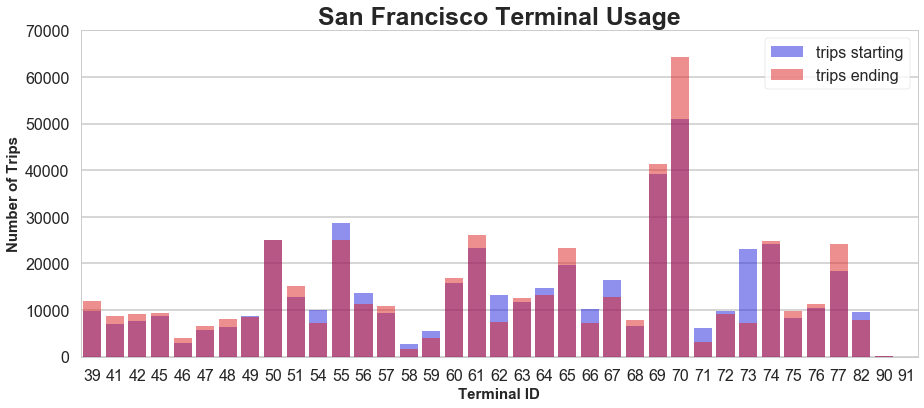

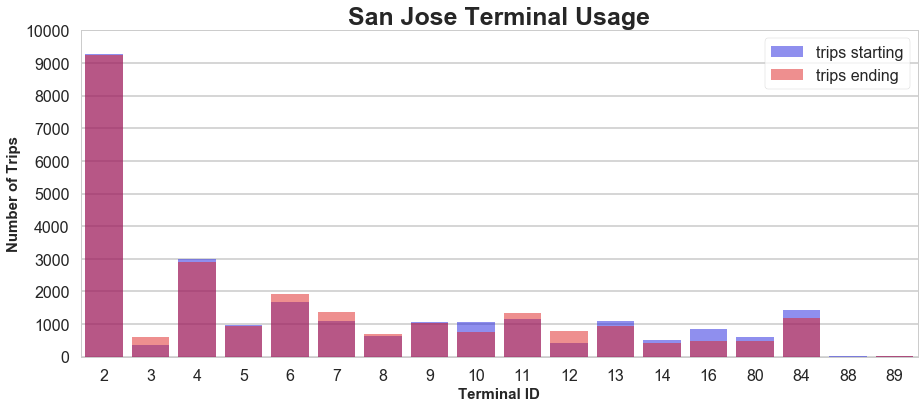

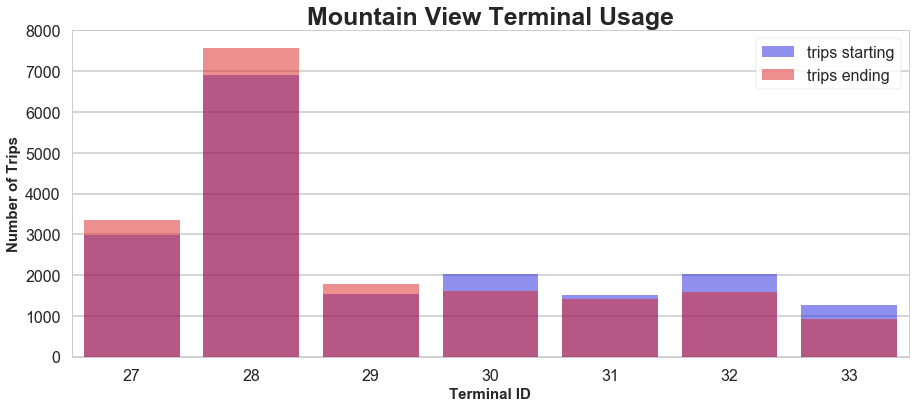

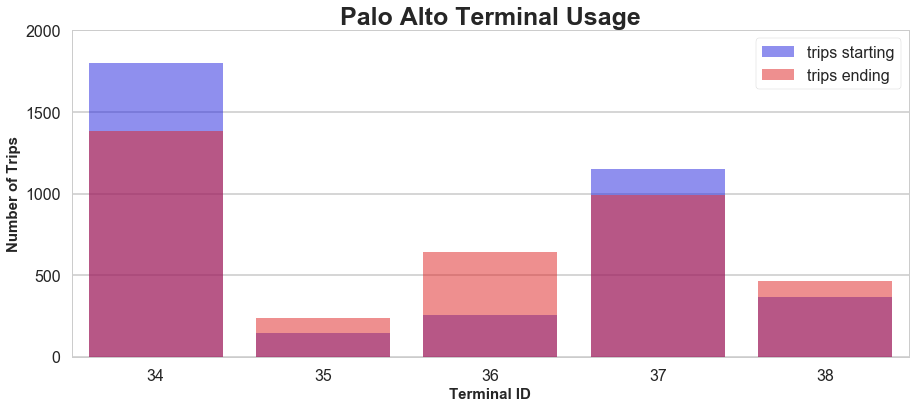

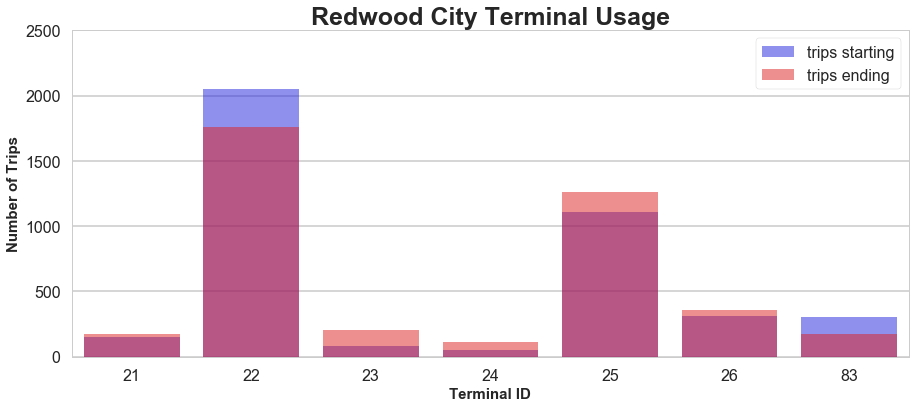

In [10]:
top_start_stations_in_region = {}
top_end_stations_in_region = {}

for zip_code in ordered_zipcodes:
    
    df = pd.DataFrame()
    
    tmp = commuter_trips_df[(commuter_trips_df.start_zip == zip_code) & (commuter_trips_df.end_zip == zip_code)]

    df = tmp.groupby('start_terminal')['trip_id'].count().to_frame()
    df.columns = ['start_count']

    df['start_share'] = popular_stations_df['start_count'] / df['start_count'].sum() * 100.
    df['end_count'] = tmp.groupby('end_terminal')['trip_id'].count().to_frame()
    
    df['end_share'] = popular_stations_df['end_count'] / df['end_count'].sum() * 100.
    
    df.index.name = 'terminal_id'
    
    # append top n to top_stations_in_region
    top_start_stations_in_region[zip_to_landmark(zip_code)] = list(df.sort_values(['start_share'], ascending=False)['start_share'].index)
    top_end_stations_in_region[zip_to_landmark(zip_code)] = list(df.sort_values(['end_share'], ascending=False)['end_share'].index)
    
    plt.subplots(figsize=(15,6))

    ax = sns.barplot(x=df.index, y = 'start_count', data=df, color='b', alpha=0.5, label='trips starting')
    sns.barplot(x=df.index, y = 'end_count', data=df, color='r', alpha=0.5, label='trips ending', ax=ax)

    title = '%s Terminal Usage' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel('Terminal ID', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')
    
    # set y axis
    y_interval = df.max().max()/5000
    
    if y_interval > 10:
        y_interval = 10000
    elif y_interval <= 10 and y_interval > 1:
        y_interval = 1000
    else:
        y_interval = 500

    y_max = -np.inf
    y_max = df.max().max()
    y_max = math.ceil(y_max/y_interval) * y_interval
    
    ax.set_ylim([0, y_max])
    ax.set_yticks([y for y in range(0, y_max+y_interval, y_interval)])
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')
    
    ax.legend(loc=1, frameon=True)
        
    image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)

    plt.show()

## Graphical EDA of Start and End Terminal Trip Counts by Region - Day Count Adjusted

## Load Station Data

In [11]:
print('[%s] Loading Status Data...' % datetime.datetime.now().time())

station_df = pd.DataFrame()
station_file = '../clean_data/bayareabikeshare/station_data_cleaned.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(station_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(station_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['first_service_date', 'last_service_date']):
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

station_df = pd.concat(chunks)

print('[%s] Complete!' % datetime.datetime.now().time())

[13:16:35.234019] Loading Status Data...
		[13:16:35.313412] finished chunk 1 of 1
[13:16:35.315478] Complete!


In [12]:
station_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 78
Data columns (total 10 columns):
station_id            79 non-null int64
name                  79 non-null object
lat                   79 non-null float64
long                  79 non-null float64
dock_count            79 non-null int64
landmark              79 non-null object
first_service_date    79 non-null datetime64[ns]
last_service_date     79 non-null datetime64[ns]
zip_code              79 non-null int64
days_in_service       79 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(4), object(2)
memory usage: 6.8+ KB


In [13]:
station_df.head()

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-29,2016-08-31,95113,1098
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-29,2016-08-31,95113,1098


# Station Data with appeneded start and end trip counts

In [14]:
def weekdays_in_service(row):
    return pd.date_range(start=row.first_service_date, end=row.last_service_date, freq='B').shape[0]

In [15]:
station_df['commuter_days'] = station_df.apply(lambda row: weekdays_in_service (row), axis=1)

In [16]:
station_df.head()

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service,commuter_days
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098,785
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098,785
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098,785
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-29,2016-08-31,95113,1098,785
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-29,2016-08-31,95113,1098,785


In [17]:
def trips_per_day(row, trips_df=None, which=''):
    '''Get numebr of trips started or ended at each terminal between terminals first and last day of service only'''
    terminal_id = row.station_id
    terminal_first_service_date = row.first_service_date
    terminal_last_service_date  = row.last_service_date
    
    if which == 'start':
        tmp = trips_df[(trips_df.start_terminal == terminal_id) & (trips_df.start_date >= terminal_first_service_date) 
                       & (trips_df.start_date < terminal_last_service_date)]
        return tmp.shape[0]
    if which == 'end':
        tmp = trips_df[(trips_df.end_terminal == terminal_id) & (trips_df.start_date >= terminal_first_service_date) 
                       & (trips_df.start_date < terminal_last_service_date)]
        return tmp.shape[0]

In [18]:
# for each station, get count of rides started from that station between first and last service dates

# append data from only trips by commuters
station_df['commuter_start_trip_count'] = station_df.apply(lambda row: trips_per_day (row, trips_df=commuter_trips_df, which='start'), axis=1)
station_df['commuter_end_trip_count']   = station_df.apply(lambda row: trips_per_day (row, trips_df=commuter_trips_df, which='end'), axis=1)

# append data from all trips
station_df['start_trip_count'] = station_df.apply(lambda row: trips_per_day (row, trips_df=trips_df, which='start'), axis=1)
station_df['end_trip_count']   = station_df.apply(lambda row: trips_per_day (row, trips_df=trips_df, which='end'), axis=1)

In [19]:
# Calculate Trips per day
station_df['commuter_trip_starts_per_day'] = station_df['commuter_start_trip_count'] / station_df['commuter_days']
station_df['commuter_trip_ends_per_day']   = station_df['commuter_end_trip_count'] / station_df['commuter_days']

station_df['trip_starts_per_day'] = station_df['start_trip_count'] / station_df['days_in_service']
station_df['trip_ends_per_day']   = station_df['end_trip_count'] / station_df['days_in_service']

In [20]:
station_df.tail()

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service,commuter_days,commuter_start_trip_count,commuter_end_trip_count,start_trip_count,end_trip_count,commuter_trip_starts_per_day,commuter_trip_ends_per_day,trip_starts_per_day,trip_ends_per_day
74,84,Ryland Park,37.342725,-121.895617,15,San Jose,2014-04-09,2016-08-31,95113,875,626,1423,1185,2554,2298,2.273163,1.892971,2.918857,2.626286
75,88,5th S. at E. San Salvador St,37.331957,-121.881630,19,San Jose,2016-07-05,2016-08-31,95113,57,42,3,3,8,5,0.071429,0.071429,0.140351,0.087719
76,89,S. Market st at Park Ave,37.332398,-121.890429,19,San Jose,2016-07-05,2016-08-31,95113,57,42,10,10,70,91,0.238095,0.238095,1.228070,1.596491
77,90,5th St at Folsom St,37.780148,-122.403158,31,San Francisco,2016-08-04,2016-08-31,94107,27,20,70,77,167,141,3.500000,3.850000,6.185185,5.222222
78,91,Cyril Magnin St at Ellis St,37.785908,-122.408891,35,San Francisco,2016-08-04,2016-08-31,94107,27,20,13,9,57,54,0.650000,0.450000,2.111111,2.000000


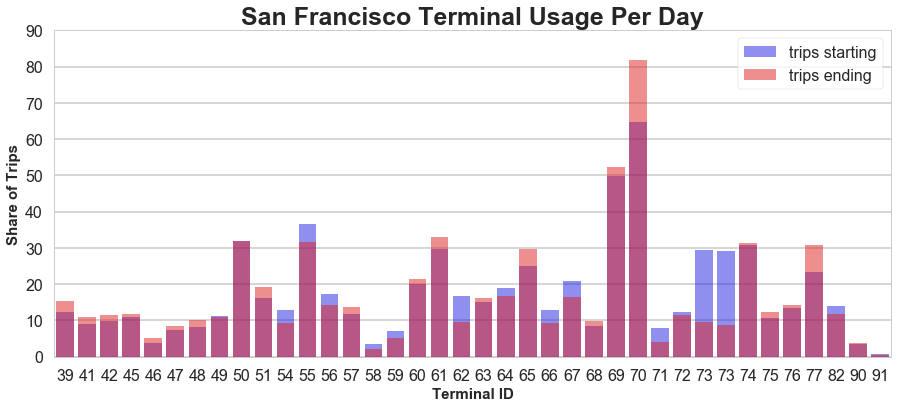

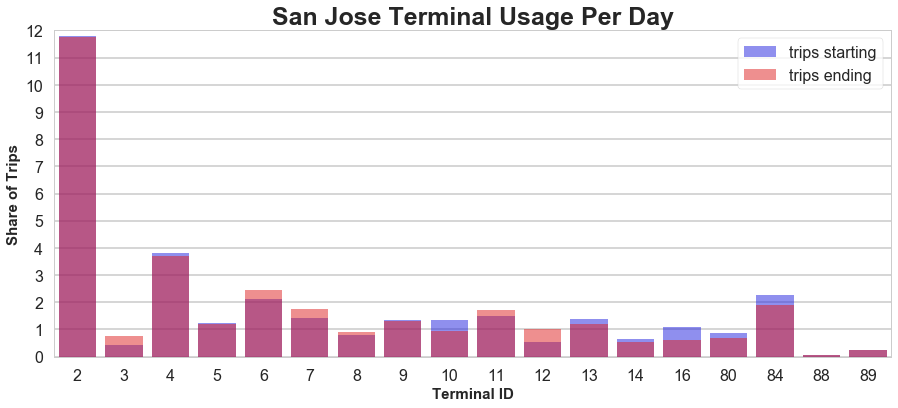

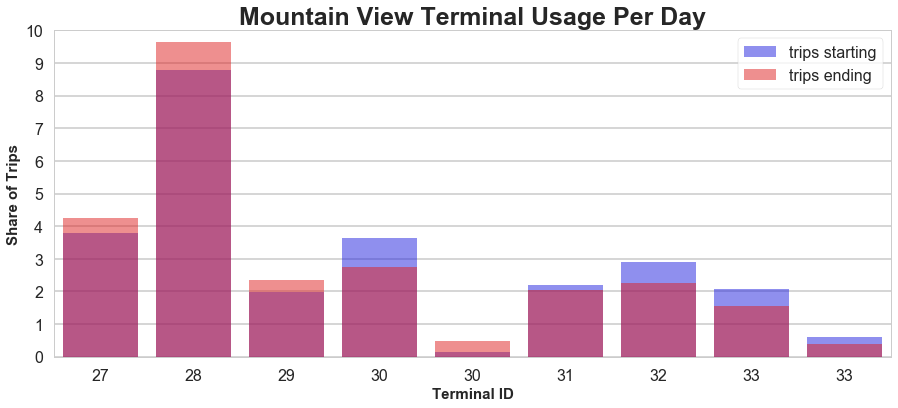

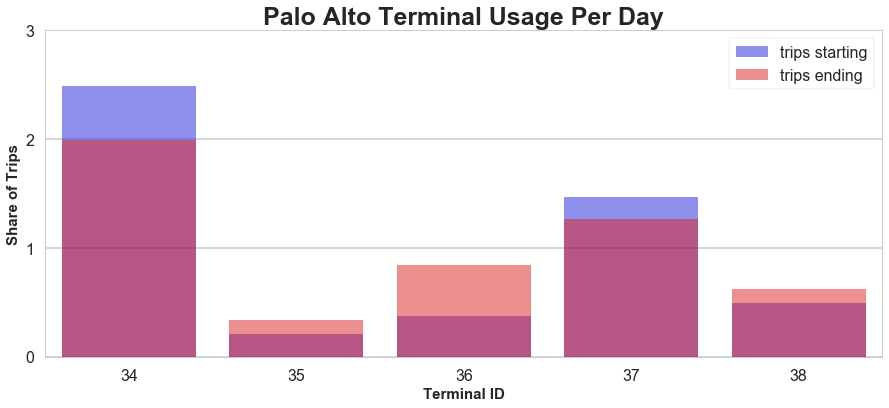

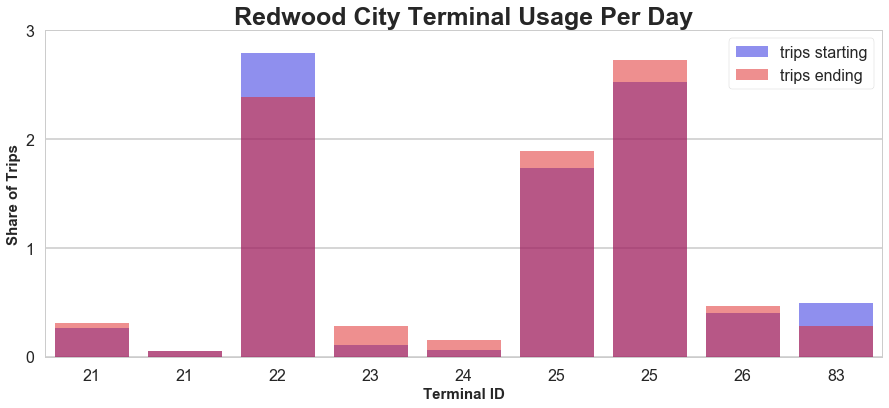

In [21]:
for zip_code in ordered_zipcodes:
    
    df = station_df[(station_df.zip_code == zip_code)]
    
    

    plt.subplots(figsize=(15,6))

    ax = sns.barplot(x=df.index, y = 'commuter_trip_starts_per_day', data=df, color='b', alpha=0.5, label='trips starting')
    sns.barplot(x=df.index, y = 'commuter_trip_ends_per_day', data=df, color='r', alpha=0.5, label='trips ending', ax=ax)

    
    ax.set_xticklabels(df.station_id)
    
    title = '%s Terminal Usage Per Day' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel('Terminal ID', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')
    
    
    y_max = -np.inf
    y_max = df['commuter_trip_ends_per_day'].max()
    
    if df['commuter_trip_starts_per_day'].max() > y_max:
        df['commuter_trip_ends_per_day'].max()
    
    y_interval = y_max/10
    
    if y_interval > 4:
        y_interval = 10
    elif y_interval < 4 and y_interval > 3:
        y_interval = 5
    else:
        y_interval = 1

    y_max = math.ceil(y_max/y_interval) * y_interval
    
    if y_max == 2:
        y_max = 3
        
    ax.set_ylim([0, y_max])
    
    ax.set_yticks([y for y in range(0, y_max+y_interval, y_interval)])
    ax.set_ylabel('Share of Trips', size=LABEL_FONT_SIZE, weight='bold')
    ax.legend(loc=1, frameon=True)
        
    image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)

    plt.show()

# Identify Popular  Commuter Routes
<p> A Route is a trip from Terminal A to Terminal B</p>

In [22]:
station_df.head()

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service,commuter_days,commuter_start_trip_count,commuter_end_trip_count,start_trip_count,end_trip_count,commuter_trip_starts_per_day,commuter_trip_ends_per_day,trip_starts_per_day,trip_ends_per_day
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098,785,9250,9238,13417,13149,11.783439,11.768153,12.219490,11.975410
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098,785,345,596,1809,2101,0.439490,0.759236,1.647541,1.913479
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098,785,2991,2902,5157,5017,3.810191,3.696815,4.696721,4.569217
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-29,2016-08-31,95113,1098,785,971,944,1969,1841,1.236943,1.202548,1.793260,1.676685
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-29,2016-08-31,95113,1098,785,1668,1931,3977,4337,2.124841,2.459873,3.622040,3.949909


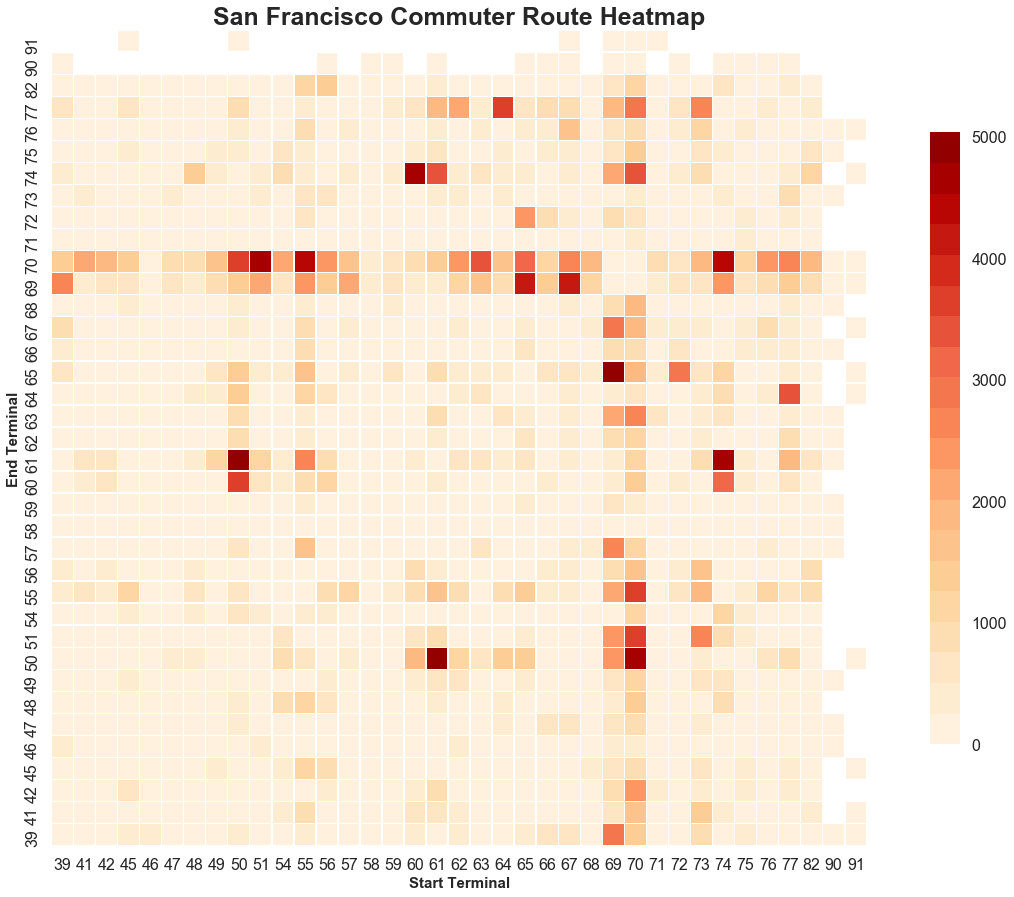

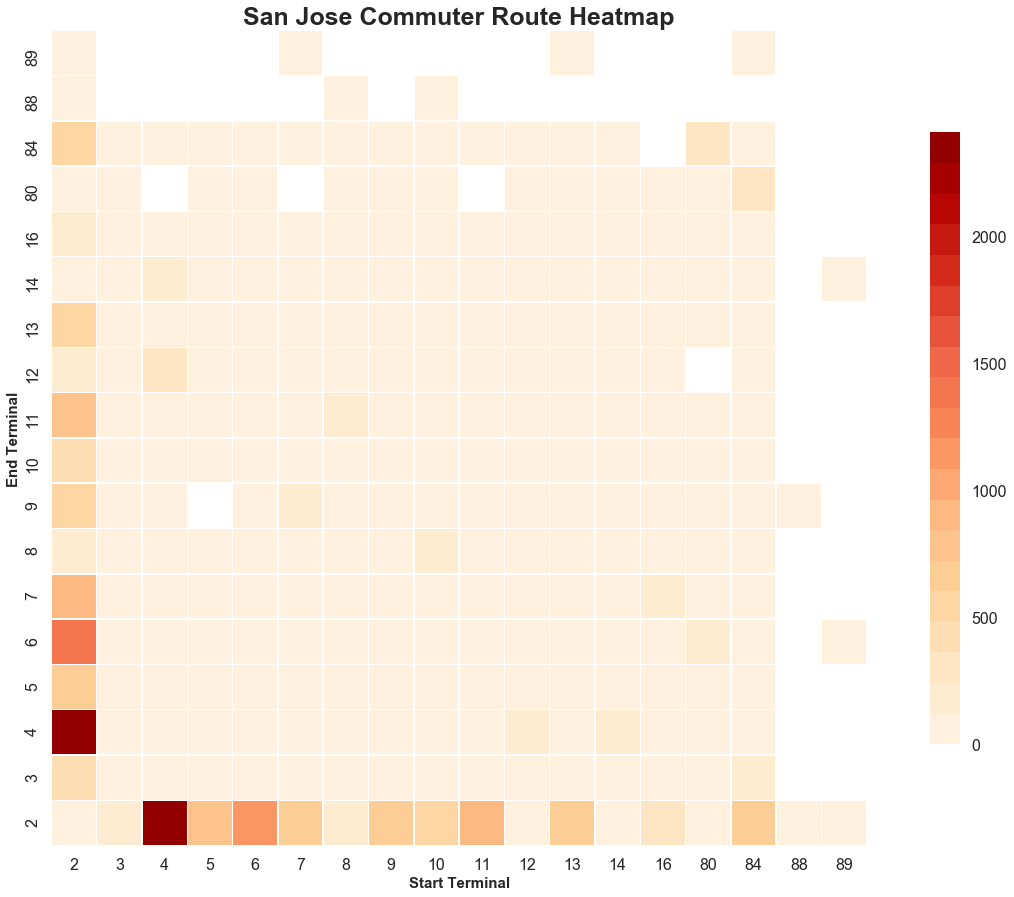

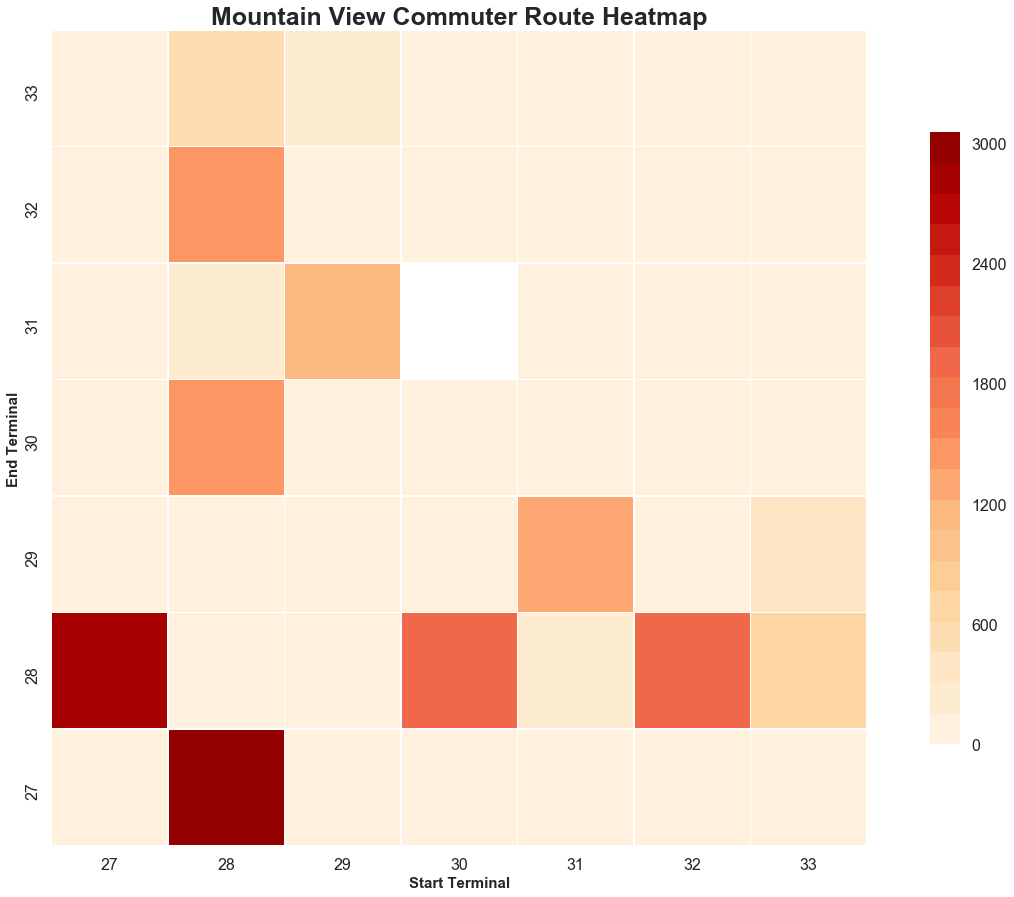

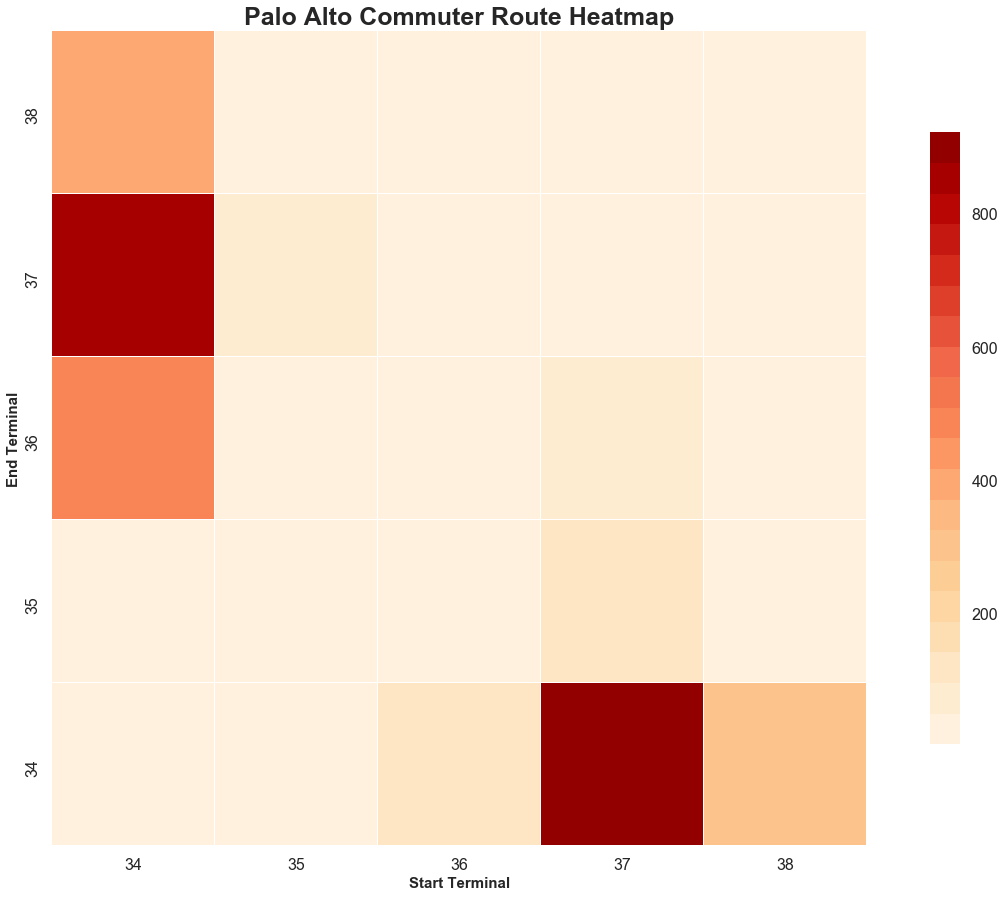

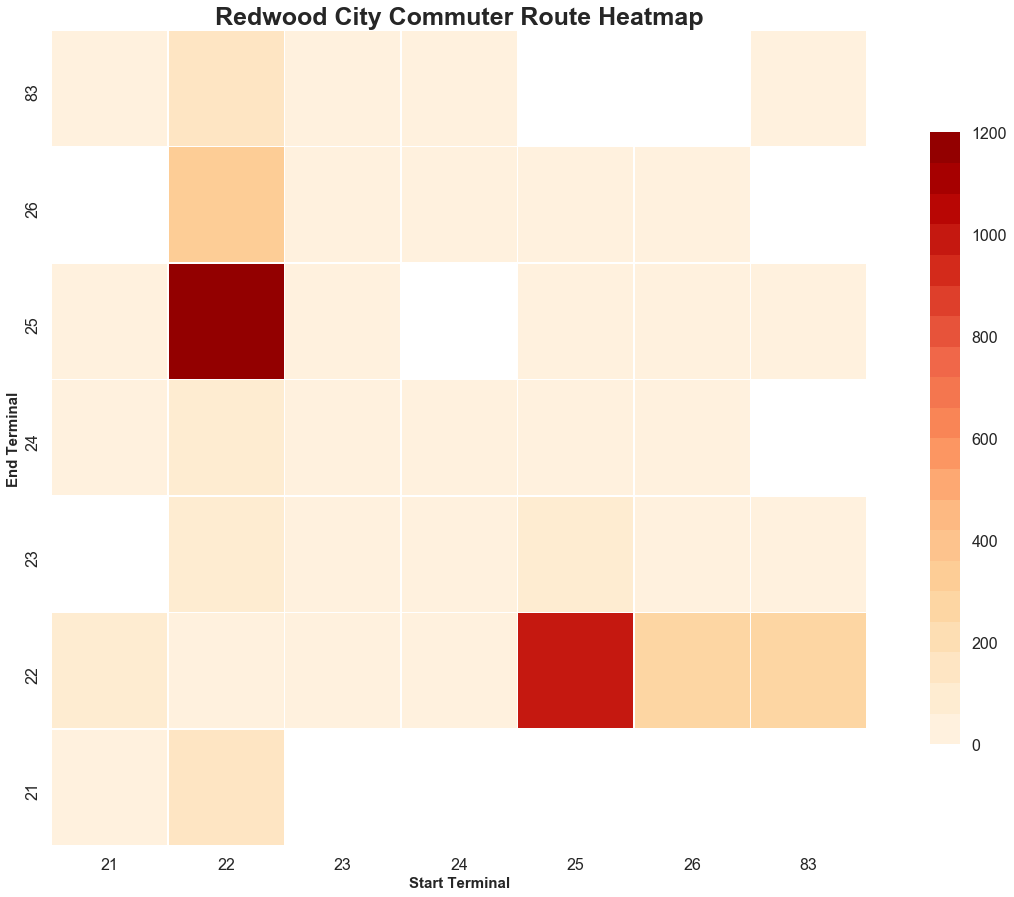

In [23]:
for zip_code in ordered_zipcodes:
    
    zip_stations = sorted(pd.unique(station_df[station_df.zip_code == zip_code]['station_id']))
    
    index   = [x for x in zip_stations]
    columns = [x for x in zip_stations]

    trip_grid = pd.DataFrame(index=index, columns=columns)
    
    # create grid of trips from start to end terminal counts
    for sid in zip_stations:
        for eid in zip_stations:
            # count trips between terminals
            route_trip_count = commuter_trips_df[(commuter_trips_df.start_terminal == sid) & (commuter_trips_df.end_terminal == eid)].shape[0]
            trip_grid.loc[eid, sid] = route_trip_count

    trip_grid = trip_grid.iloc[::-1]
    
    # drop nan rows and columns
    trip_grid.dropna(axis=0, how='all', inplace=True)
    trip_grid.dropna(axis=1, how='all', inplace=True)
    
    mask = trip_grid == 0
    grid_dims = 15
    fig, ax = plt.subplots(figsize=(grid_dims*1.5, grid_dims))
    
    sns.heatmap(data=trip_grid, linewidths=.5, square=True, cmap=sns.color_palette("OrRd", 20), mask=mask, ax=ax, cbar_kws={"shrink": .75}, cbar=True)
    
    ax.set_xlabel('Start Terminal', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel('End Terminal', size=LABEL_FONT_SIZE, weight='bold')
    
    title = '%s Commuter Route Heatmap' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)

    plt.show()

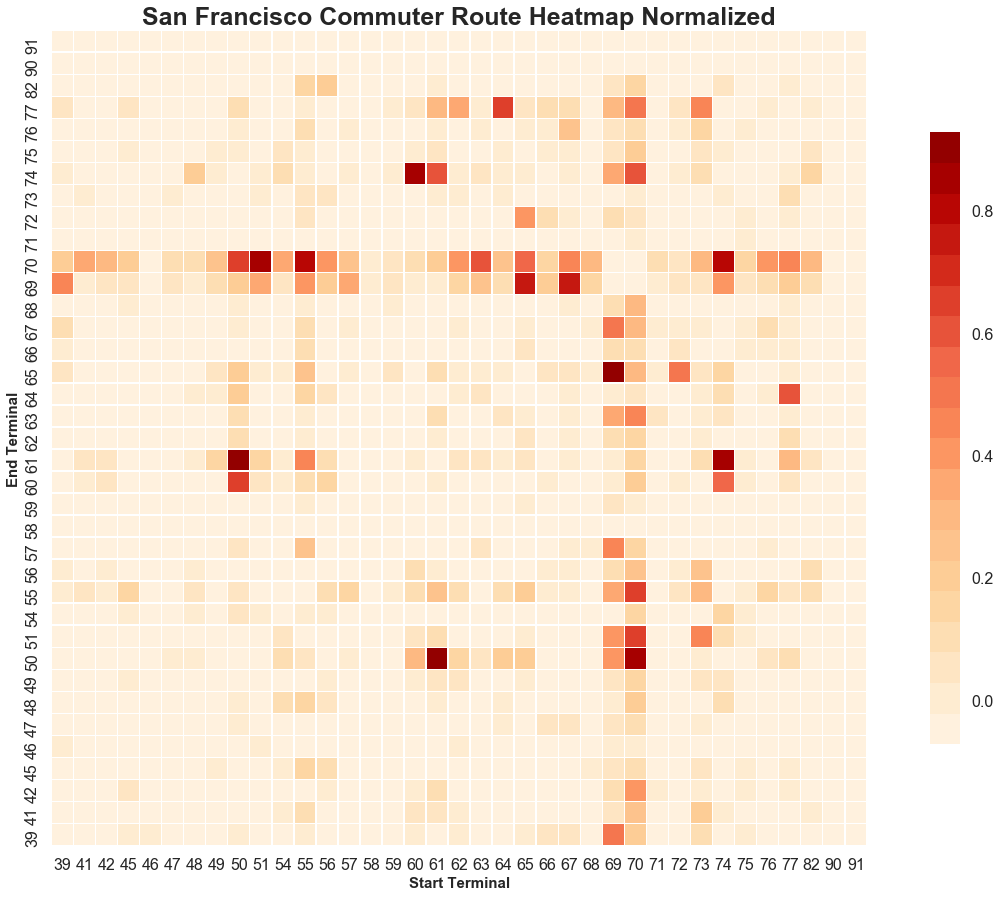

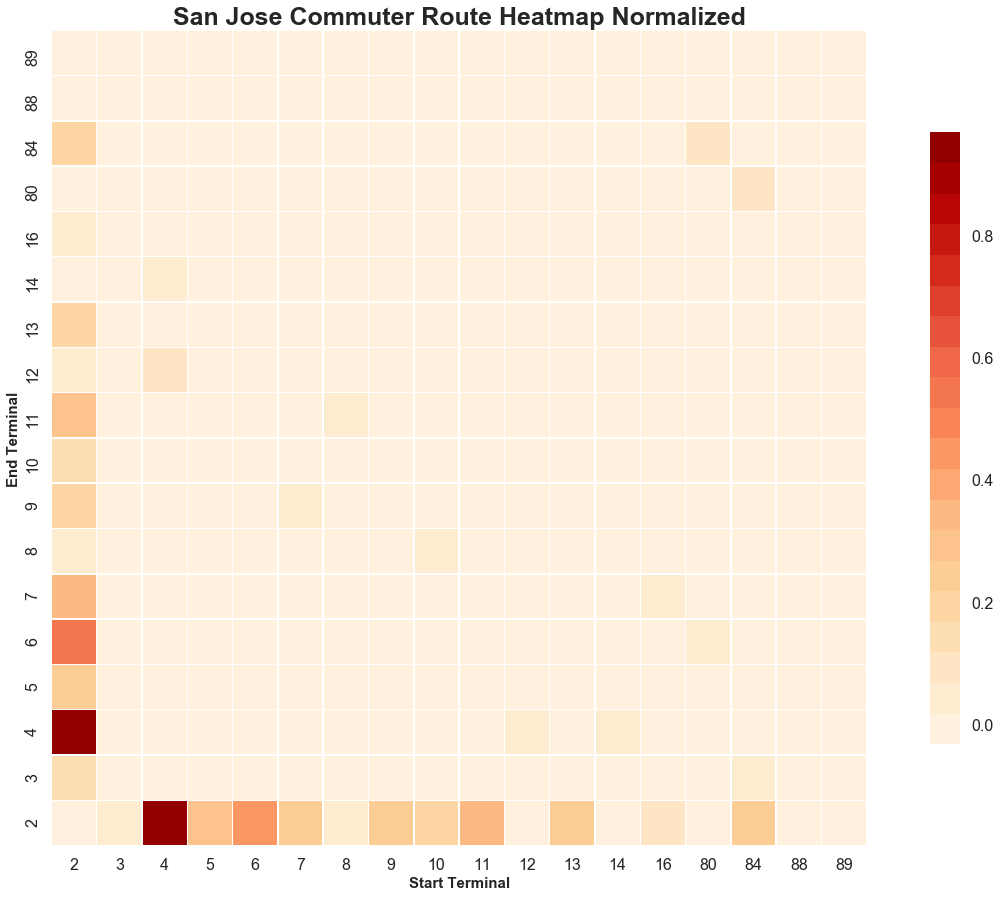

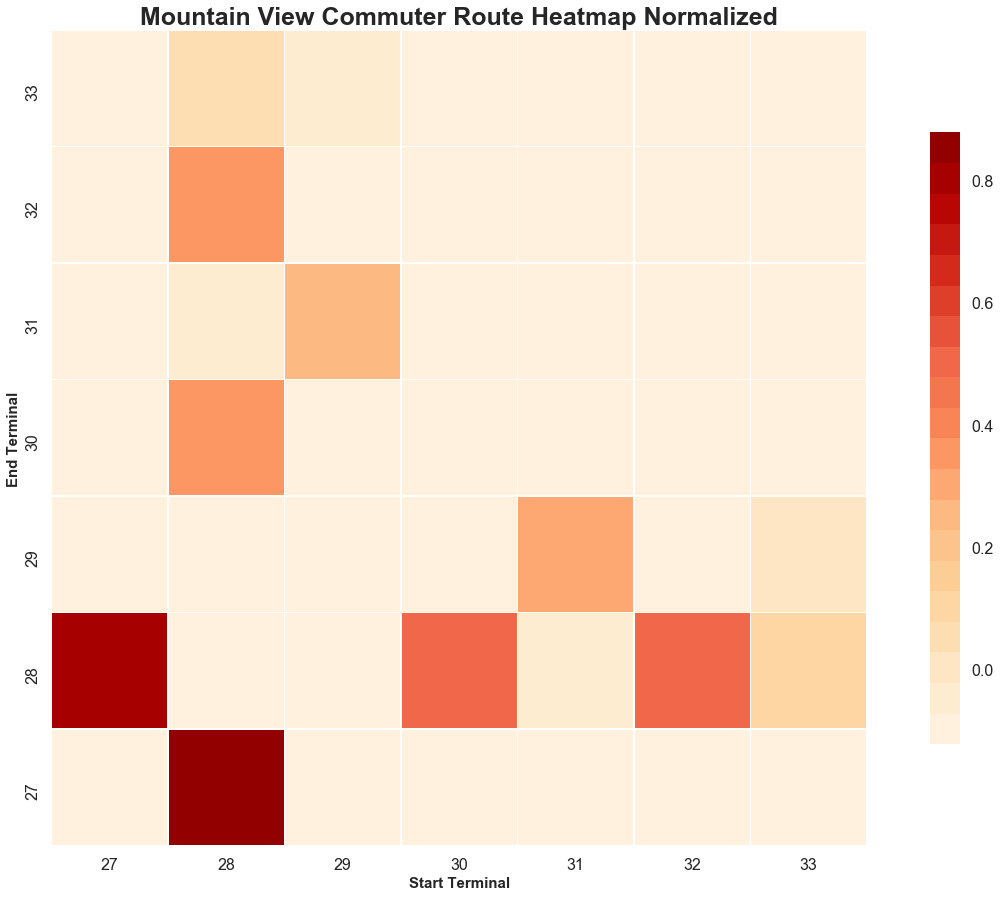

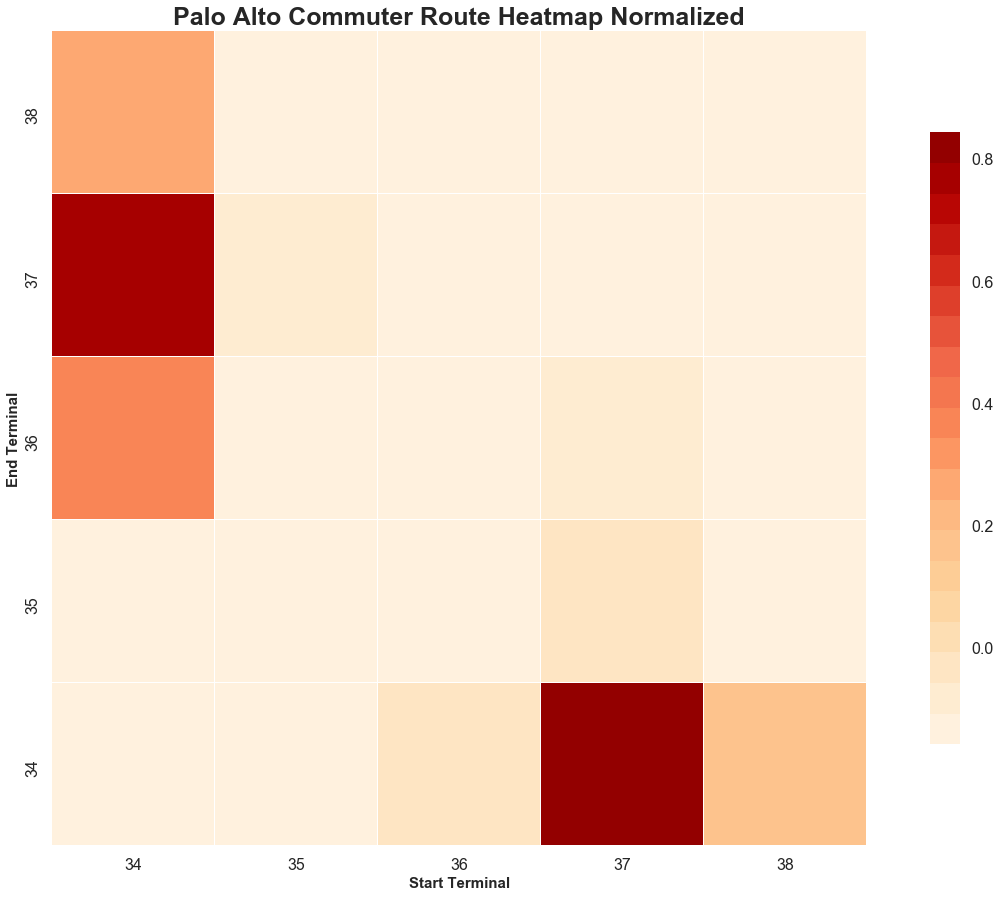

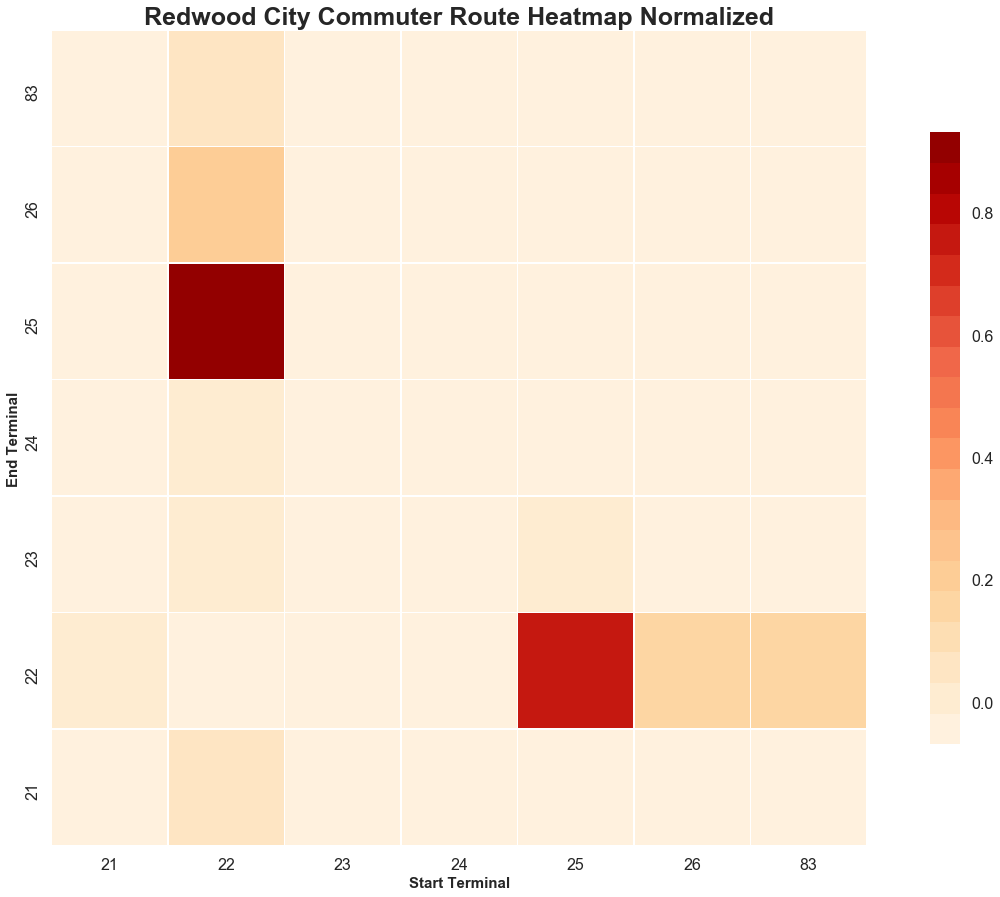

In [24]:
for zip_code in ordered_zipcodes:
    
    zip_stations = sorted(pd.unique(station_df[station_df.zip_code == zip_code]['station_id']))
    
    index   = [x for x in zip_stations]
    columns = [x for x in zip_stations]

    trip_grid = pd.DataFrame(index=index, columns=columns)
    
    # create grid of trips from start to end terminal counts
    for sid in zip_stations:
        for eid in zip_stations:
            # count trips between terminals
            route_trip_count = commuter_trips_df[(commuter_trips_df.start_terminal == sid) & (commuter_trips_df.end_terminal == eid)].shape[0]
            trip_grid.loc[eid, sid] = route_trip_count

    trip_grid = trip_grid.iloc[::-1]
    
    # drop nan rows and columns
    trip_grid.dropna(axis=0, how='all', inplace=True)
    trip_grid.dropna(axis=1, how='all', inplace=True)
    
    # normalize trip grid    
    trip_grid = (trip_grid - trip_grid.mean().mean()) / (trip_grid.max().max() - trip_grid.min().min())

    mask = trip_grid == 0
    grid_dims = 15
    fig, ax = plt.subplots(figsize=(grid_dims*1.5, grid_dims))
    
    sns.heatmap(data=trip_grid, linewidths=.5, square=True, cmap=sns.color_palette("OrRd", 20), mask=mask, ax=ax, cbar_kws={"shrink": .75}, cbar=True)
    
    ax.set_xlabel('Start Terminal', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel('End Terminal', size=LABEL_FONT_SIZE, weight='bold')
    
    title = '%s Commuter Route Heatmap Normalized' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)

    plt.show()

# Identify Top Start and End Stations Used by Commuters

In [25]:
station_df.head(3)

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service,commuter_days,commuter_start_trip_count,commuter_end_trip_count,start_trip_count,end_trip_count,commuter_trip_starts_per_day,commuter_trip_ends_per_day,trip_starts_per_day,trip_ends_per_day
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098,785,9250,9238,13417,13149,11.783439,11.768153,12.219490,11.975410
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098,785,345,596,1809,2101,0.439490,0.759236,1.647541,1.913479
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098,785,2991,2902,5157,5017,3.810191,3.696815,4.696721,4.569217


In [26]:
for zip_code in ordered_zipcodes:
    print(zip_to_landmark(zip_code))
    print('-' * 80)
    
    df = pd.DataFrame()
    df = station_df[station_df.zip_code == zip_code].copy()
    df.sort_values('commuter_start_trip_count', ascending=False, inplace=True)
    df_trip_count = df.commuter_start_trip_count.head(10).tolist()
    df_station_name = df.name.head(10).tolist()
    
    df = df[['station_id', 'name', 'commuter_start_trip_count']].head(10)
    top_stations = df.station_id.tolist()
    
    print('Top Commuter Start Terminals by Total Trip Count')
    print('\tID -  Trips - Trip Share')
    for i, sid in enumerate(top_stations):
        trip_share = df_trip_count[i]/sum(df_trip_count)*100.
        trip_share = '{:2.4f}'.format(trip_share)
        
        print('\t%s - %s - %s - %s' % (str(sid).rjust(2), str(df_trip_count[i]).rjust(6), trip_share.rjust(7),  df_station_name[i]))
    
    print('')
    df = pd.DataFrame()
    df = station_df[station_df.zip_code == zip_code].copy()
    df.sort_values('commuter_end_trip_count', ascending=False, inplace=True)
    df_trip_count = df.commuter_end_trip_count.head(10).tolist()
    df_station_name = df.name.head(10).tolist()
    
    df = df[['station_id', 'name', 'commuter_end_trip_count']].head(10)
    top_stations = df.station_id.tolist()
    
    print('Top Commuter End Terminals by Total Trip Count')
    print('\tID -  Trips - Trip Share')
    for i, sid in enumerate(top_stations):
        trip_share = df_trip_count[i]/sum(df_trip_count)*100.
        trip_share = '{:2.4f}'.format(trip_share)
        
        print('\t%s - %s - %s - %s' % (str(sid).rjust(2), str(df_trip_count[i]).rjust(6), trip_share.rjust(7),  df_station_name[i]))

    print('')

San Francisco
--------------------------------------------------------------------------------
Top Commuter Start Terminals by Total Trip Count
	ID -  Trips - Trip Share
	70 -  50851 - 19.4463 - San Francisco Caltrain (Townsend at 4th)
	69 -  39212 - 14.9954 - San Francisco Caltrain 2 (330 Townsend)
	55 -  28705 - 10.9773 - Temporary Transbay Terminal (Howard at Beale)
	50 -  25013 -  9.5654 - Harry Bridges Plaza (Ferry Building)
	74 -  24229 -  9.2656 - Steuart at Market
	61 -  23234 -  8.8851 - 2nd at Townsend
	65 -  19640 -  7.5107 - Townsend at 7th
	77 -  18398 -  7.0357 - Market at Sansome
	67 -  16446 -  6.2892 - Market at 10th
	60 -  15766 -  6.0292 - Embarcadero at Sansome

Top Commuter End Terminals by Total Trip Count
	ID -  Trips - Trip Share
	70 -  64257 - 22.5137 - San Francisco Caltrain (Townsend at 4th)
	69 -  41177 - 14.4272 - San Francisco Caltrain 2 (330 Townsend)
	61 -  25985 -  9.1044 - 2nd at Townsend
	50 -  25019 -  8.7659 - Harry Bridges Plaza (Ferry Building)
	5

# Split Trips into Morning and Evening Commute Hours

In [27]:
morning_commuter_trips_df.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,end_zip,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN


In [28]:
evening_commuter_trips_df.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,end_zip,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
378,4692,1150,2013-08-29 16:02:00,Beale at Market,56,2013-08-29 16:21:00,South Van Ness at Market,66,320,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
386,4701,828,2013-08-29 16:14:00,Harry Bridges Plaza (Ferry Building),50,2013-08-29 16:27:00,Market at 4th,76,372,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
387,4702,804,2013-08-29 16:14:00,Harry Bridges Plaza (Ferry Building),50,2013-08-29 16:27:00,Market at 4th,76,592,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN


## Append Morning Commute Station Data

In [29]:
# for each station, get count of rides started from that station between first and last service dates

# append data from only trips by commuters
station_df['morning_commuter_start_trip_count'] = station_df.apply(lambda row: trips_per_day (row, trips_df=morning_commuter_trips_df, which='start'), axis=1)
station_df['morning_commuter_end_trip_count']   = station_df.apply(lambda row: trips_per_day (row, trips_df=morning_commuter_trips_df, which='end'), axis=1)

# Calculate Trips per day
station_df['morning_commuter_trip_starts_per_day'] = station_df['morning_commuter_start_trip_count'] / station_df['commuter_days']
station_df['morning_commuter_trip_ends_per_day']   = station_df['morning_commuter_end_trip_count'] / station_df['commuter_days']

## Append Evening Commute Station Data

In [30]:
# for each station, get count of rides started from that station between first and last service dates

# append data from only trips by commuters
station_df['evening_commuter_start_trip_count'] = station_df.apply(lambda row: trips_per_day (row, trips_df=evening_commuter_trips_df, which='start'), axis=1)
station_df['evening_commuter_end_trip_count']   = station_df.apply(lambda row: trips_per_day (row, trips_df=evening_commuter_trips_df, which='end'), axis=1)

# Calculate Trips per day
station_df['evening_commuter_trip_starts_per_day'] = station_df['evening_commuter_start_trip_count'] / station_df['commuter_days']
station_df['evening_commuter_trip_ends_per_day']   = station_df['evening_commuter_end_trip_count'] / station_df['commuter_days']

In [31]:
station_df.columns

Index(['station_id', 'name', 'lat', 'long', 'dock_count', 'landmark',
       'first_service_date', 'last_service_date', 'zip_code',
       'days_in_service', 'commuter_days', 'commuter_start_trip_count',
       'commuter_end_trip_count', 'start_trip_count', 'end_trip_count',
       'commuter_trip_starts_per_day', 'commuter_trip_ends_per_day',
       'trip_starts_per_day', 'trip_ends_per_day',
       'morning_commuter_start_trip_count', 'morning_commuter_end_trip_count',
       'morning_commuter_trip_starts_per_day',
       'morning_commuter_trip_ends_per_day',
       'evening_commuter_start_trip_count', 'evening_commuter_end_trip_count',
       'evening_commuter_trip_starts_per_day',
       'evening_commuter_trip_ends_per_day'],
      dtype='object')

## Plot Heatmap of Morning Routes

In [32]:
morning_commuter_trips_df.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,end_zip,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN


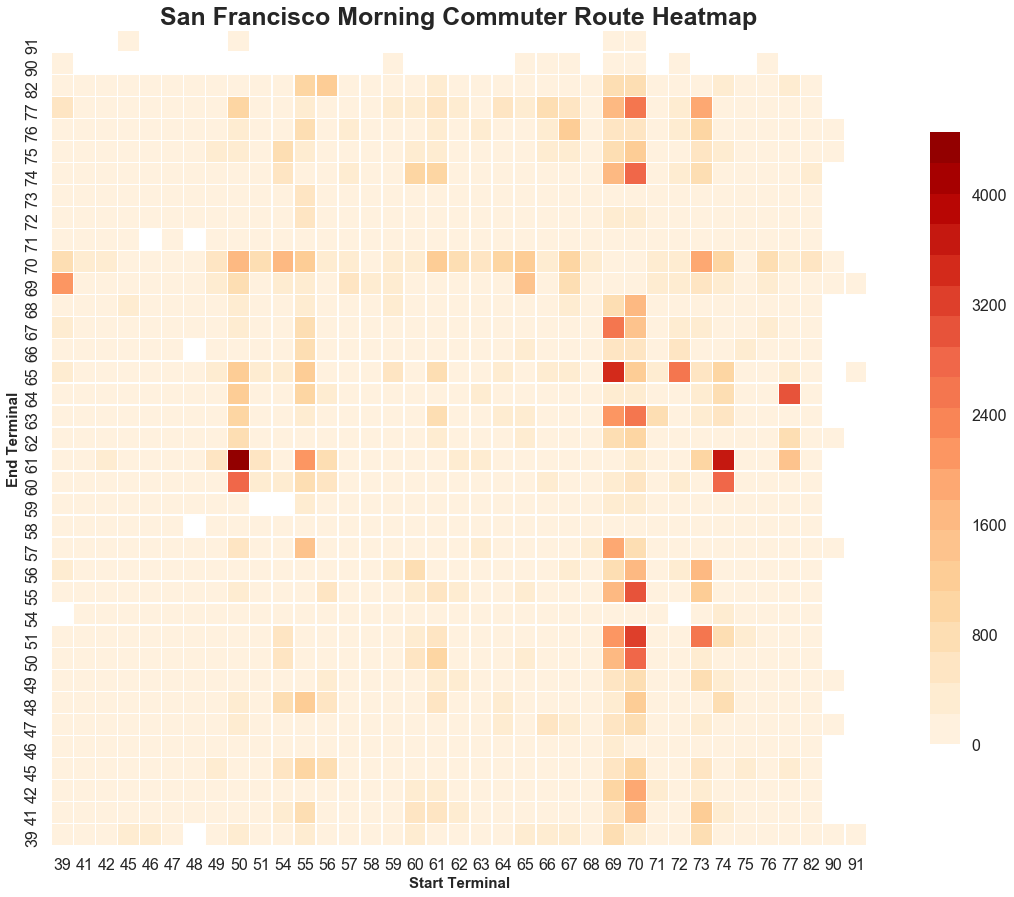

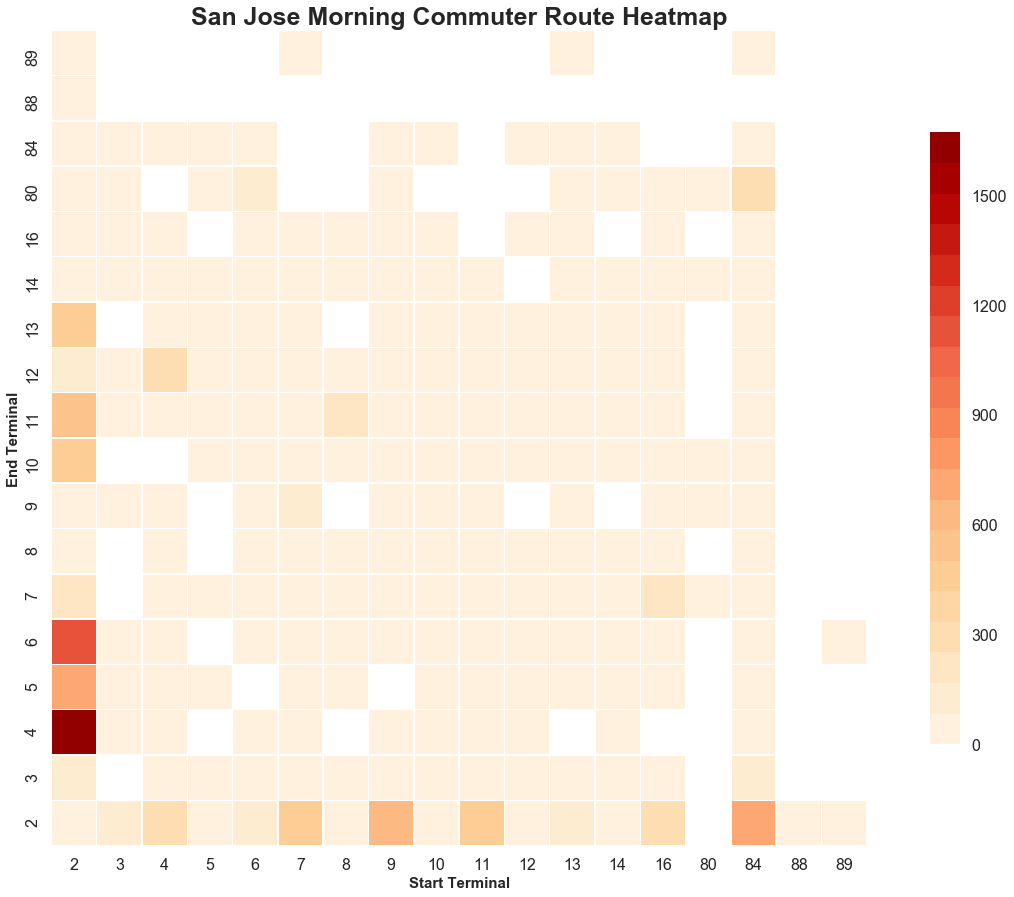

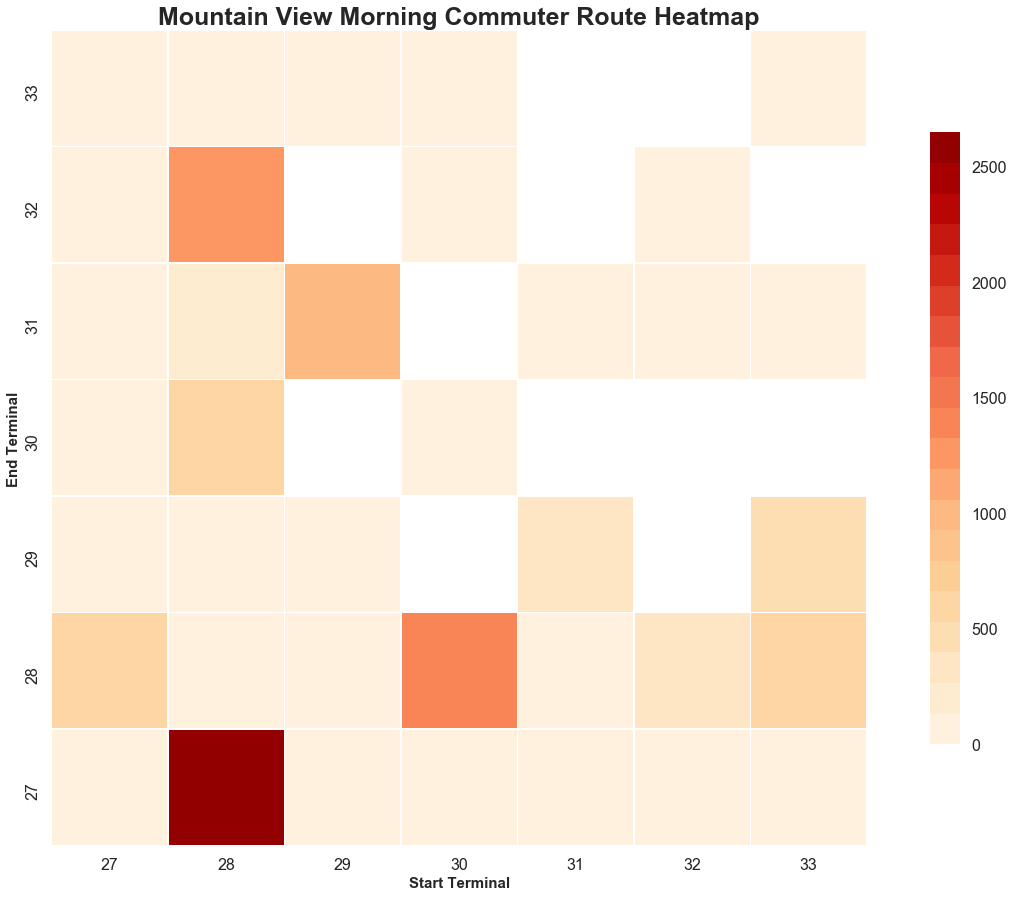

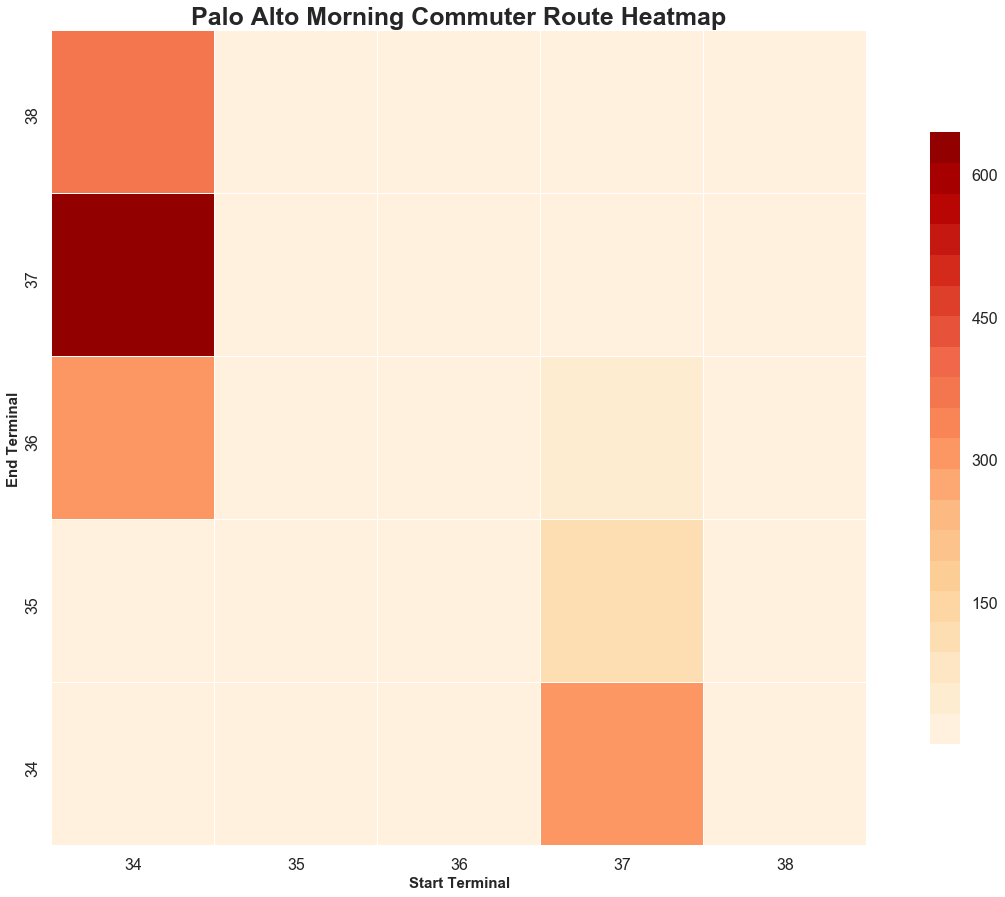

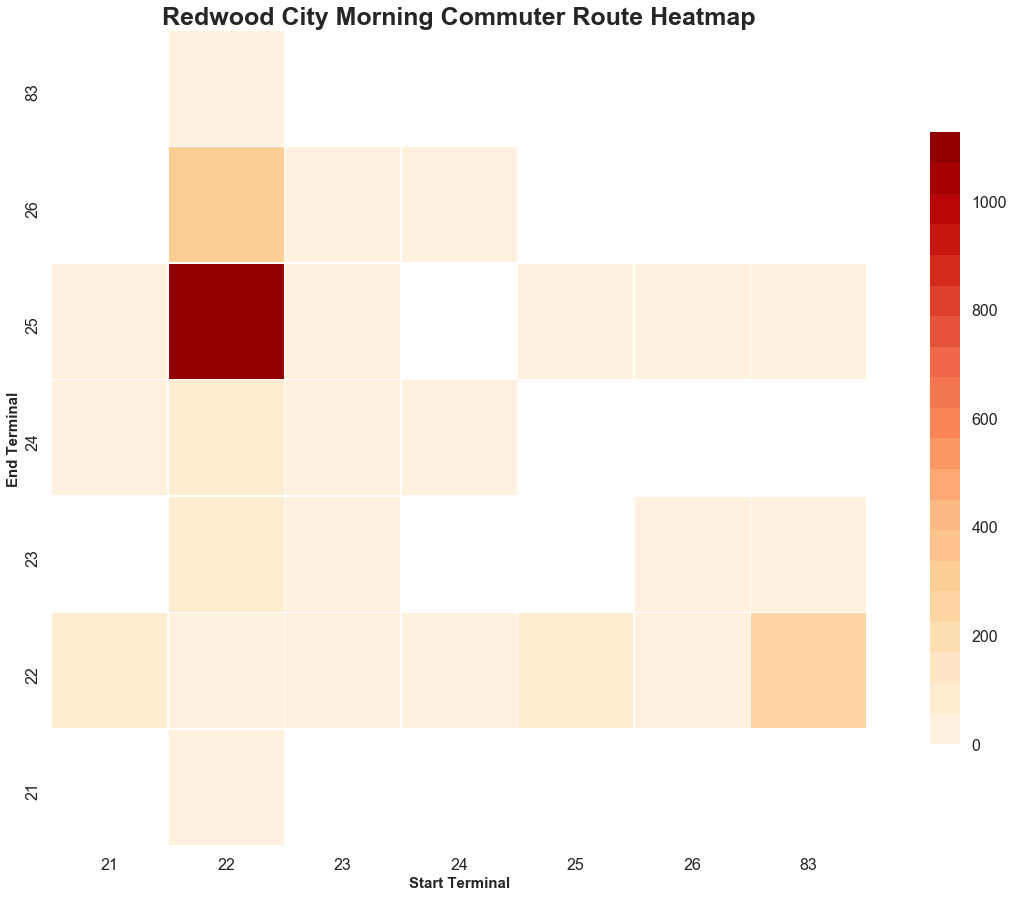

In [33]:
for zip_code in ordered_zipcodes:

    df = morning_commuter_trips_df[(morning_commuter_trips_df.start_zip == zip_code) & (morning_commuter_trips_df.end_zip == zip_code)].copy()

    start_stations = sorted(pd.unique(df.start_terminal))
    end_stations = sorted(pd.unique(df.end_terminal))

    stations = start_stations

    for s in end_stations:
        if s not in stations:
            stations.append(s)

    index   = [x for x in stations]
    columns = [x for x in stations]

    trip_grid = pd.DataFrame(index=index, columns=columns)

    # create grid of trips from start to end terminal counts
    for sid in stations:
        for eid in stations:
            # count trips between terminals
            route_trip_count = df[(df.start_terminal == sid) & (df.end_terminal == eid)].shape[0]
            trip_grid.loc[eid, sid] = route_trip_count

    trip_grid = trip_grid.iloc[::-1]

    # drop nan rows and columns
    trip_grid.dropna(axis=0, how='all', inplace=True)
    trip_grid.dropna(axis=1, how='all', inplace=True)

    mask = trip_grid == 0
    grid_dims = 15
    fig, ax = plt.subplots(figsize=(grid_dims*1.5, grid_dims))

    sns.heatmap(data=trip_grid, linewidths=.5, square=True, cmap=sns.color_palette("OrRd", 20), mask=mask, ax=ax, cbar_kws={"shrink": .75}, cbar=True)

    ax.set_xlabel('Start Terminal', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel('End Terminal', size=LABEL_FONT_SIZE, weight='bold')

    title = '%s Morning Commuter Route Heatmap' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)

    plt.show()

In [34]:
for zip_code in ordered_zipcodes:
    print(zip_to_landmark(zip_code))
    print('-' * 80)
    
    df = pd.DataFrame()
    df = station_df[station_df.zip_code == zip_code].copy()
    df.sort_values('morning_commuter_start_trip_count', ascending=False, inplace=True)
    df_trip_count = df.morning_commuter_start_trip_count.head(10).tolist()
    df_station_name = df.name.head(10).tolist()
    
    df = df[['station_id', 'name', 'morning_commuter_start_trip_count']].head(10)
    top_stations = df.station_id.tolist()
    
    print('Top Morning Commuter Start Terminals by Total Trip Count')
    print('\tID -  Trips - Trip Share')
    for i, sid in enumerate(top_stations):
        trip_share = df_trip_count[i]/sum(df_trip_count)*100.
        trip_share = '{:2.4f}'.format(trip_share)
        
        print('\t%s - %s - %s - %s' % (str(sid).rjust(2), str(df_trip_count[i]).rjust(6), trip_share.rjust(7),  df_station_name[i]))
    
    print('')
    df = pd.DataFrame()
    df = station_df[station_df.zip_code == zip_code].copy()
    df.sort_values('morning_commuter_end_trip_count', ascending=False, inplace=True)
    df_trip_count = df.morning_commuter_end_trip_count.head(10).tolist()
    df_station_name = df.name.head(10).tolist()
    
    df = df[['station_id', 'name', 'morning_commuter_end_trip_count']].head(10)
    top_stations = df.station_id.tolist()
    
    print('Top Morning Commuter End Terminals by Total Trip Count')
    print('\tID -  Trips - Trip Share')
    for i, sid in enumerate(top_stations):
        trip_share = df_trip_count[i]/sum(df_trip_count)*100.
        trip_share = '{:2.4f}'.format(trip_share)
        
        print('\t%s - %s - %s - %s' % (str(sid).rjust(2), str(df_trip_count[i]).rjust(6), trip_share.rjust(7),  df_station_name[i]))

    print('')

San Francisco
--------------------------------------------------------------------------------
Top Morning Commuter Start Terminals by Total Trip Count
	ID -  Trips - Trip Share
	70 -  37887 - 22.8970 - San Francisco Caltrain (Townsend at 4th)
	69 -  29751 - 17.9800 - San Francisco Caltrain 2 (330 Townsend)
	50 -  19126 - 11.5588 - Harry Bridges Plaza (Ferry Building)
	55 -  19113 - 11.5509 - Temporary Transbay Terminal (Howard at Beale)
	74 -  14468 -  8.7437 - Steuart at Market
	73 -  11248 -  6.7977 - Grant Avenue at Columbus Avenue
	61 -  10419 -  6.2967 - 2nd at Townsend
	73 -   8488 -  5.1297 - Grant Avenue at Columbus Avenue
	77 -   7600 -  4.5931 - Market at Sansome
	67 -   7367 -  4.4522 - Market at 10th

Top Morning Commuter End Terminals by Total Trip Count
	ID -  Trips - Trip Share
	70 -  20789 - 15.6715 - San Francisco Caltrain (Townsend at 4th)
	61 -  17361 - 13.0873 - 2nd at Townsend
	65 -  16605 - 12.5174 - Townsend at 7th
	77 -  13556 - 10.2190 - Market at Sansome
	51 

## Plot Heatmap of Evening Routes

In [35]:
evening_commuter_trips_df.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,end_zip,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
378,4692,1150,2013-08-29 16:02:00,Beale at Market,56,2013-08-29 16:21:00,South Van Ness at Market,66,320,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
386,4701,828,2013-08-29 16:14:00,Harry Bridges Plaza (Ferry Building),50,2013-08-29 16:27:00,Market at 4th,76,372,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
387,4702,804,2013-08-29 16:14:00,Harry Bridges Plaza (Ferry Building),50,2013-08-29 16:27:00,Market at 4th,76,592,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN


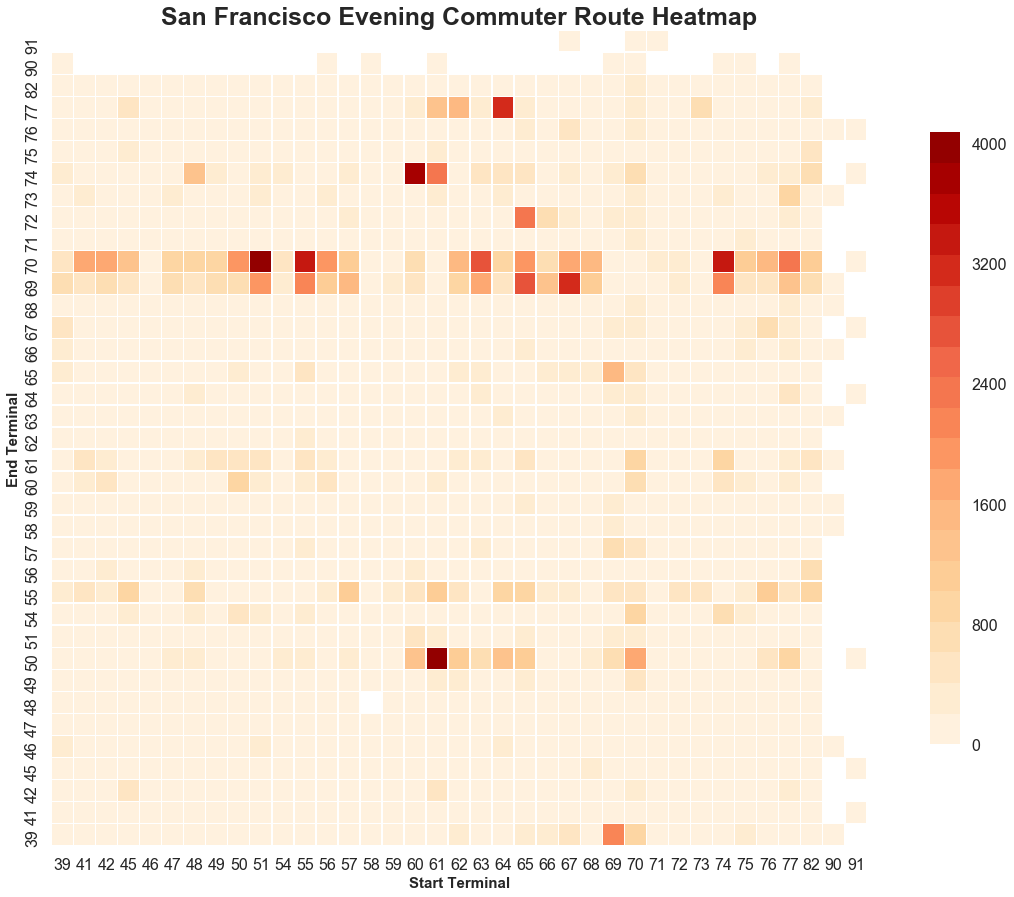

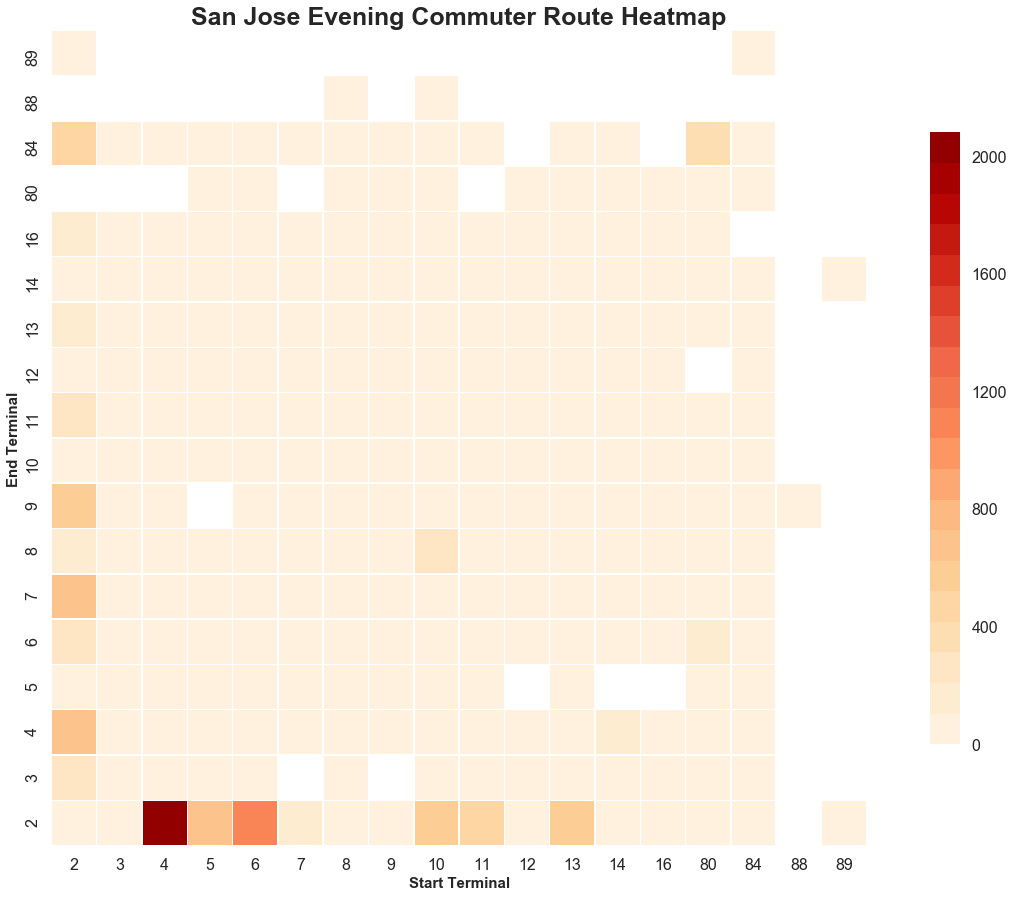

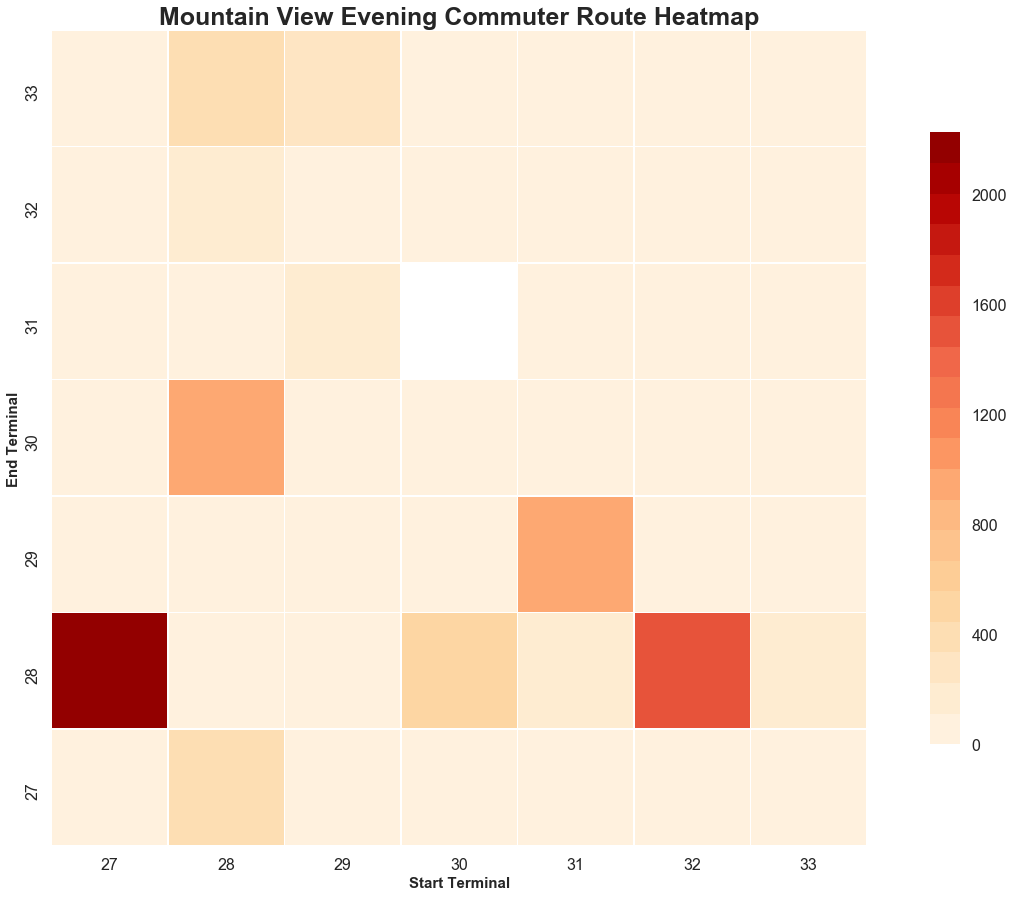

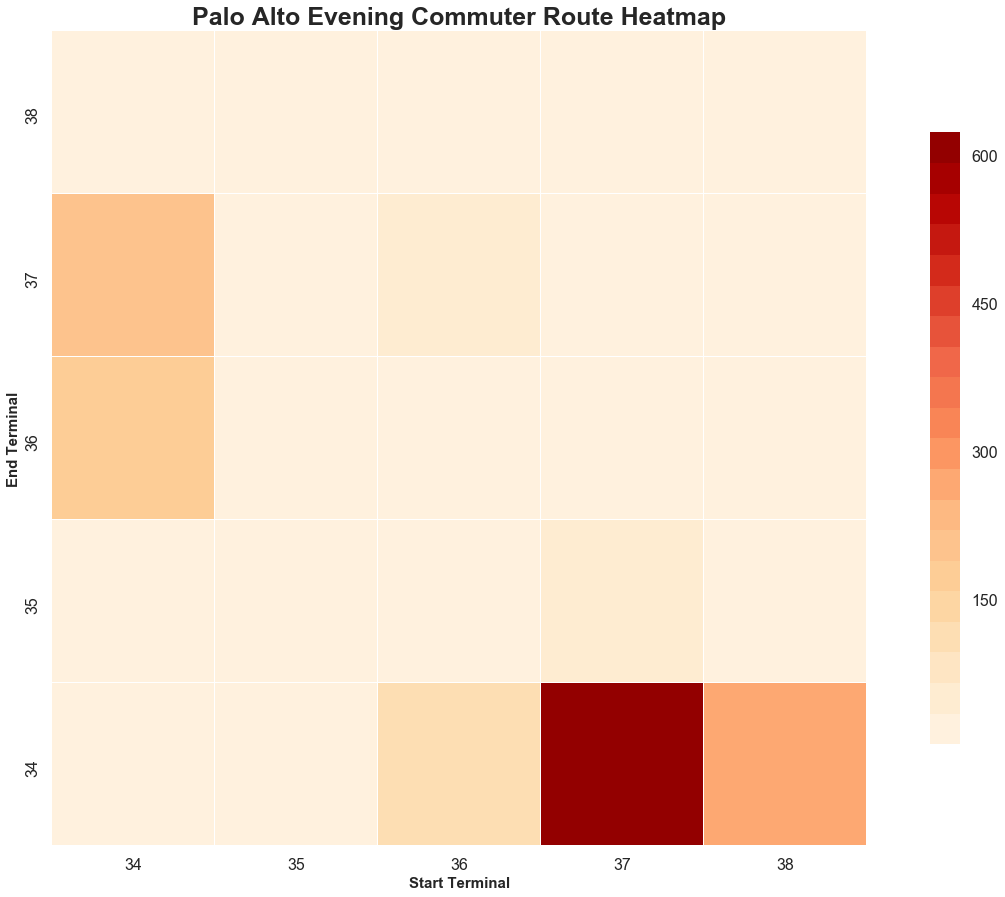

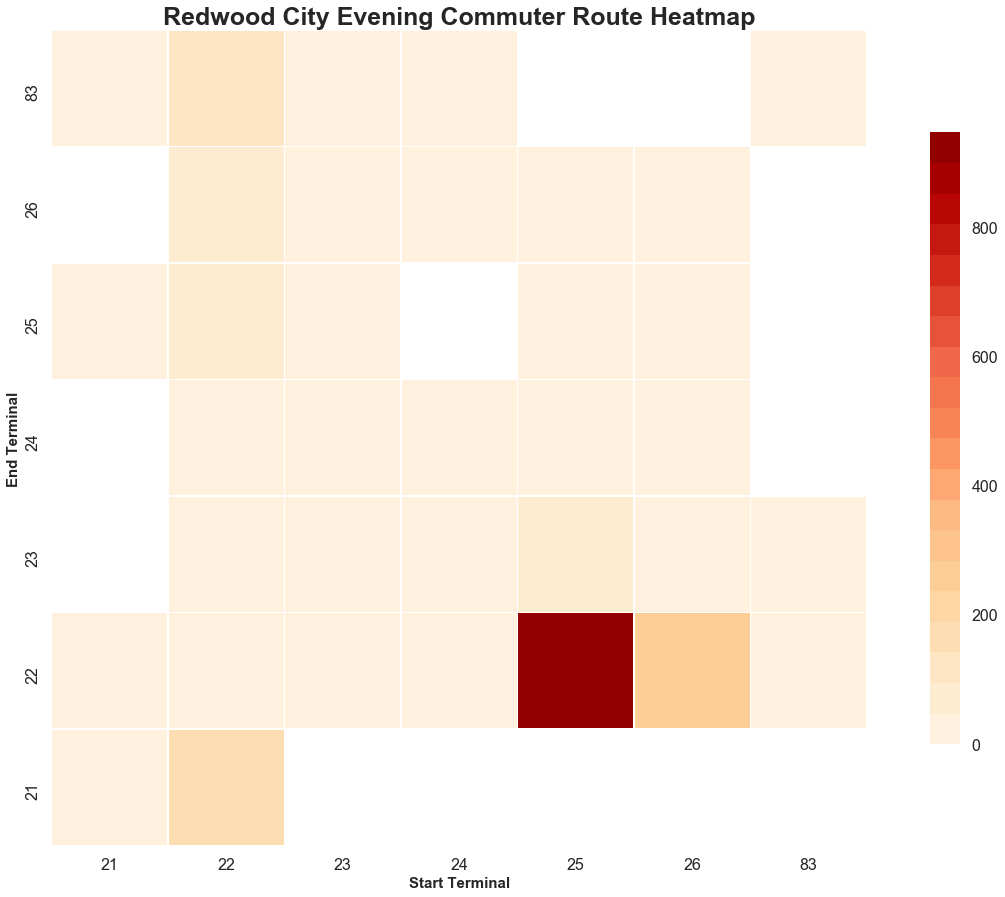

In [36]:
for zip_code in ordered_zipcodes:

    df = evening_commuter_trips_df[(evening_commuter_trips_df.start_zip == zip_code) & (evening_commuter_trips_df.end_zip == zip_code)].copy()

    start_stations = sorted(pd.unique(df.start_terminal))
    end_stations = sorted(pd.unique(df.end_terminal))

    stations = start_stations

    for s in end_stations:
        if s not in stations:
            stations.append(s)

    index   = [x for x in stations]
    columns = [x for x in stations]

    trip_grid = pd.DataFrame(index=index, columns=columns)

    # create grid of trips from start to end terminal counts
    for sid in stations:
        for eid in stations:
            # count trips between terminals
            route_trip_count = df[(df.start_terminal == sid) & (df.end_terminal == eid)].shape[0]
            trip_grid.loc[eid, sid] = route_trip_count

    trip_grid = trip_grid.iloc[::-1]

    # drop nan rows and columns
    trip_grid.dropna(axis=0, how='all', inplace=True)
    trip_grid.dropna(axis=1, how='all', inplace=True)

    mask = trip_grid == 0
    grid_dims = 15
    fig, ax = plt.subplots(figsize=(grid_dims*1.5, grid_dims))

    sns.heatmap(data=trip_grid, linewidths=.5, square=True, cmap=sns.color_palette("OrRd", 20), mask=mask, ax=ax, cbar_kws={"shrink": .75}, cbar=True)

    ax.set_xlabel('Start Terminal', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel('End Terminal', size=LABEL_FONT_SIZE, weight='bold')

    title = '%s Evening Commuter Route Heatmap' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)

    plt.show()

In [37]:
for zip_code in ordered_zipcodes:
    print(zip_to_landmark(zip_code))
    print('-' * 80)
    
    df = pd.DataFrame()
    df = station_df[station_df.zip_code == zip_code].copy()
    df.sort_values('evening_commuter_start_trip_count', ascending=False, inplace=True)
    df_trip_count = df.evening_commuter_start_trip_count.head(10).tolist()
    df_station_name = df.name.head(10).tolist()
    
    df = df[['station_id', 'name', 'evening_commuter_start_trip_count']].head(10)
    top_stations = df.station_id.tolist()
    
    print('Top Evening Commuter Start Terminals by Total Trip Count')
    print('\tID -  Trips - Trip Share')
    for i, sid in enumerate(top_stations):
        trip_share = df_trip_count[i]/sum(df_trip_count)*100.
        trip_share = '{:2.4f}'.format(trip_share)
        
        print('\t%s - %s - %s - %s' % (str(sid).rjust(2), str(df_trip_count[i]).rjust(6), trip_share.rjust(7),  df_station_name[i]))
    
    print('')
    df = pd.DataFrame()
    df = station_df[station_df.zip_code == zip_code].copy()
    df.sort_values('evening_commuter_end_trip_count', ascending=False, inplace=True)
    df_trip_count = df.evening_commuter_end_trip_count.head(10).tolist()
    df_station_name = df.name.head(10).tolist()
    
    df = df[['station_id', 'name', 'evening_commuter_end_trip_count']].head(10)
    top_stations = df.station_id.tolist()
    
    print('Top Evening Commuter End Terminals by Total Trip Count')
    print('\tID -  Trips - Trip Share')
    for i, sid in enumerate(top_stations):
        trip_share = df_trip_count[i]/sum(df_trip_count)*100.
        trip_share = '{:2.4f}'.format(trip_share)
        
        print('\t%s - %s - %s - %s' % (str(sid).rjust(2), str(df_trip_count[i]).rjust(6), trip_share.rjust(7),  df_station_name[i]))

    print('')

San Francisco
--------------------------------------------------------------------------------
Top Evening Commuter Start Terminals by Total Trip Count
	ID -  Trips - Trip Share
	65 -  13486 - 12.4459 - Townsend at 7th
	70 -  12964 - 11.9642 - San Francisco Caltrain (Townsend at 4th)
	61 -  12815 - 11.8266 - 2nd at Townsend
	77 -  10798 -  9.9652 - Market at Sansome
	64 -  10226 -  9.4373 - 2nd at South Park
	60 -   9915 -  9.1503 - Embarcadero at Sansome
	74 -   9761 -  9.0082 - Steuart at Market
	55 -   9592 -  8.8522 - Temporary Transbay Terminal (Howard at Beale)
	69 -   9461 -  8.7313 - San Francisco Caltrain 2 (330 Townsend)
	51 -   9339 -  8.6187 - Embarcadero at Folsom

Top Evening Commuter End Terminals by Total Trip Count
	ID -  Trips - Trip Share
	70 -  43468 - 27.4326 - San Francisco Caltrain (Townsend at 4th)
	69 -  30306 - 19.1261 - San Francisco Caltrain 2 (330 Townsend)
	50 -  16802 - 10.6037 - Harry Bridges Plaza (Ferry Building)
	55 -  14723 -  9.2917 - Temporary Tran

# Regional Commuter Influx

 27267 more Commuters are arriving in San Francisco in the morning than are departing in the afternoon


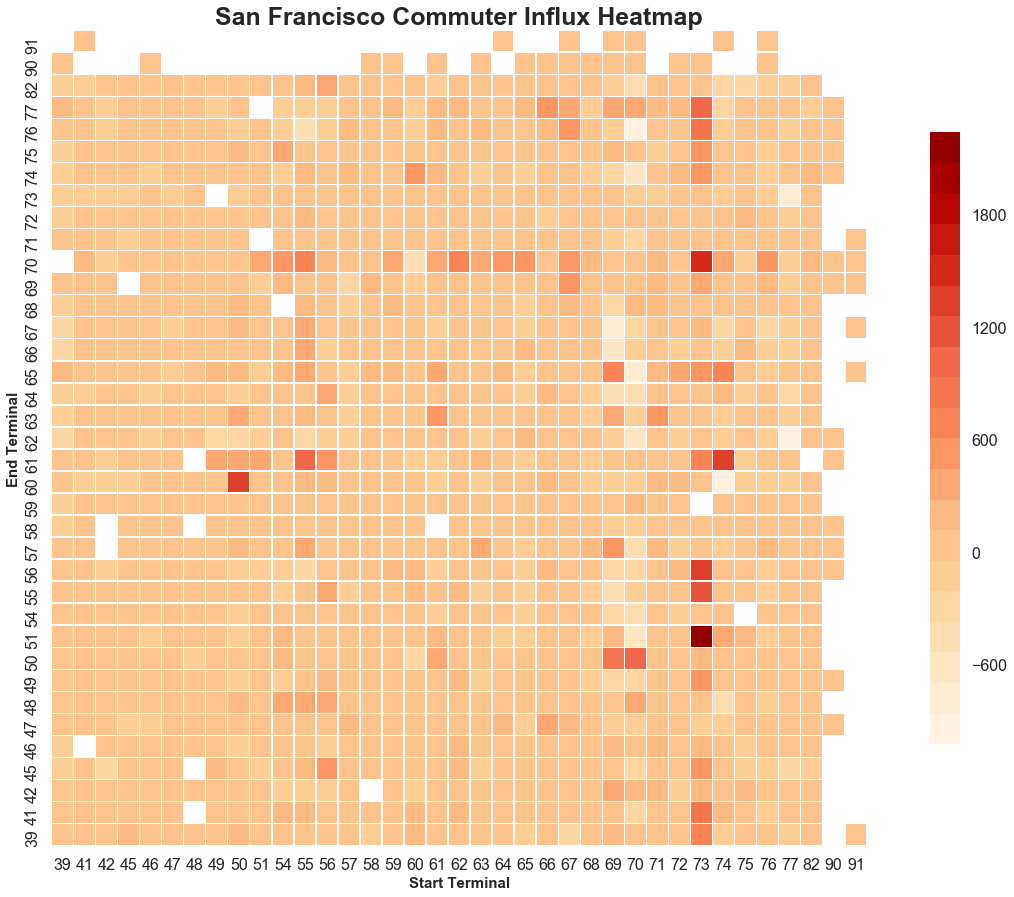

  2141 fewer Commuters are arriving in San Jose in the morning than are departing in the afternoon


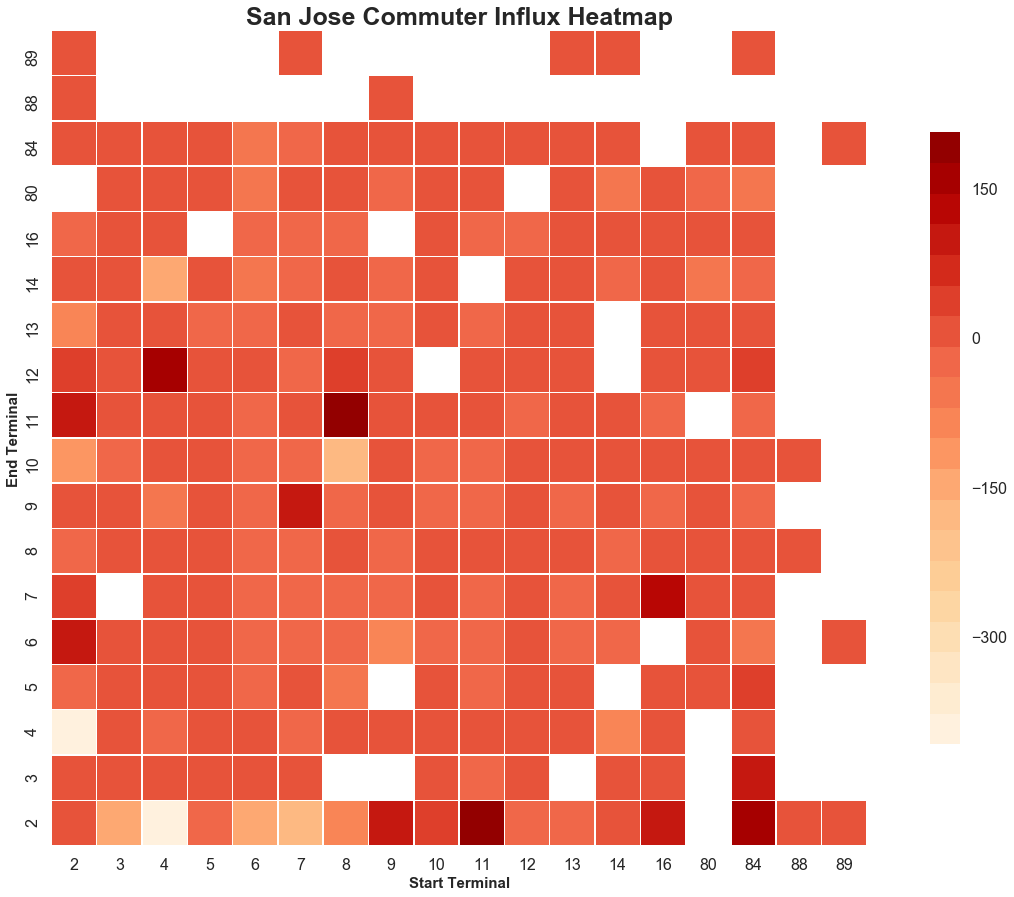

   992 more Commuters are arriving in Mountain View in the morning than are departing in the afternoon


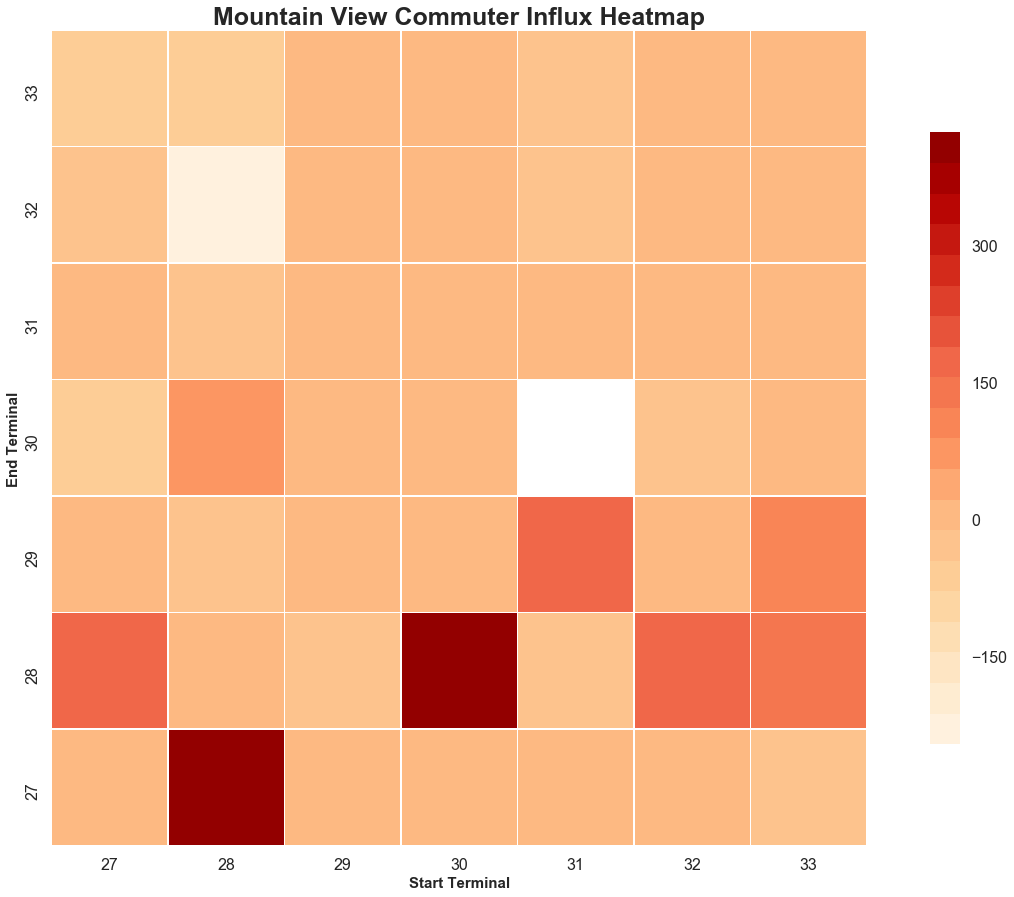

   202 more Commuters are arriving in Palo Alto in the morning than are departing in the afternoon


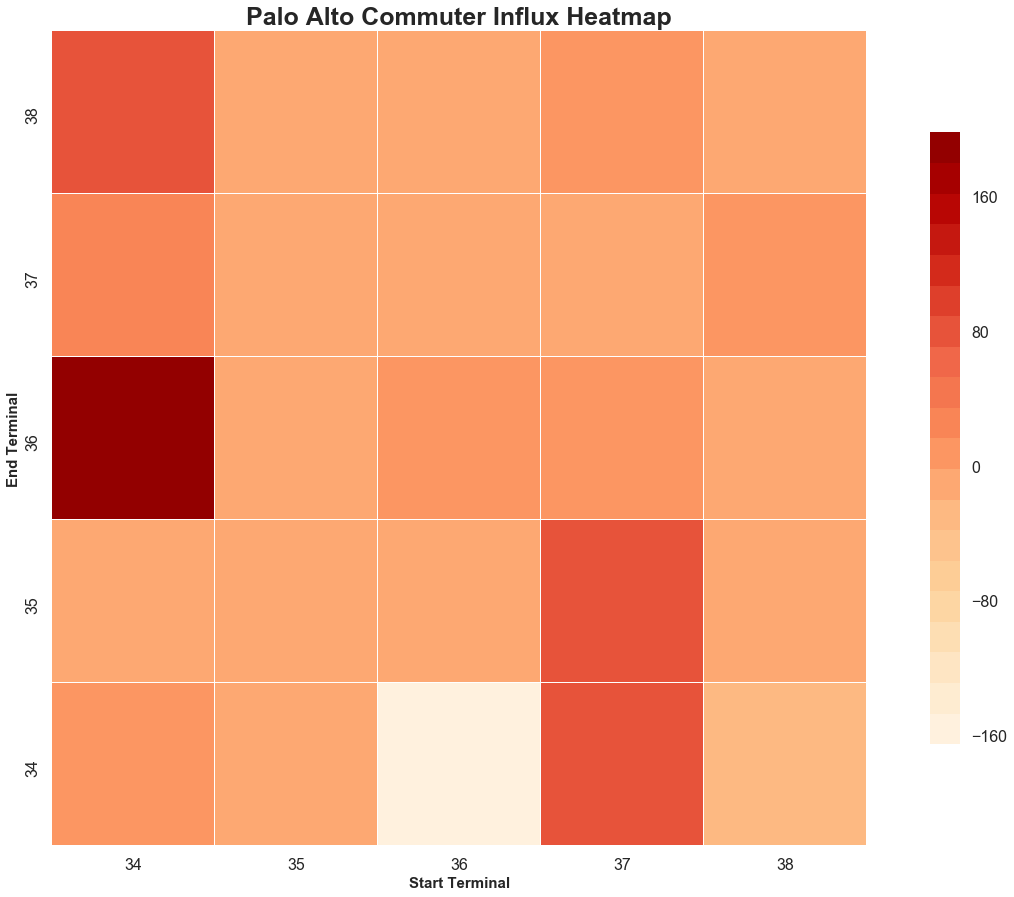

   223 more Commuters are arriving in Redwood City in the morning than are departing in the afternoon


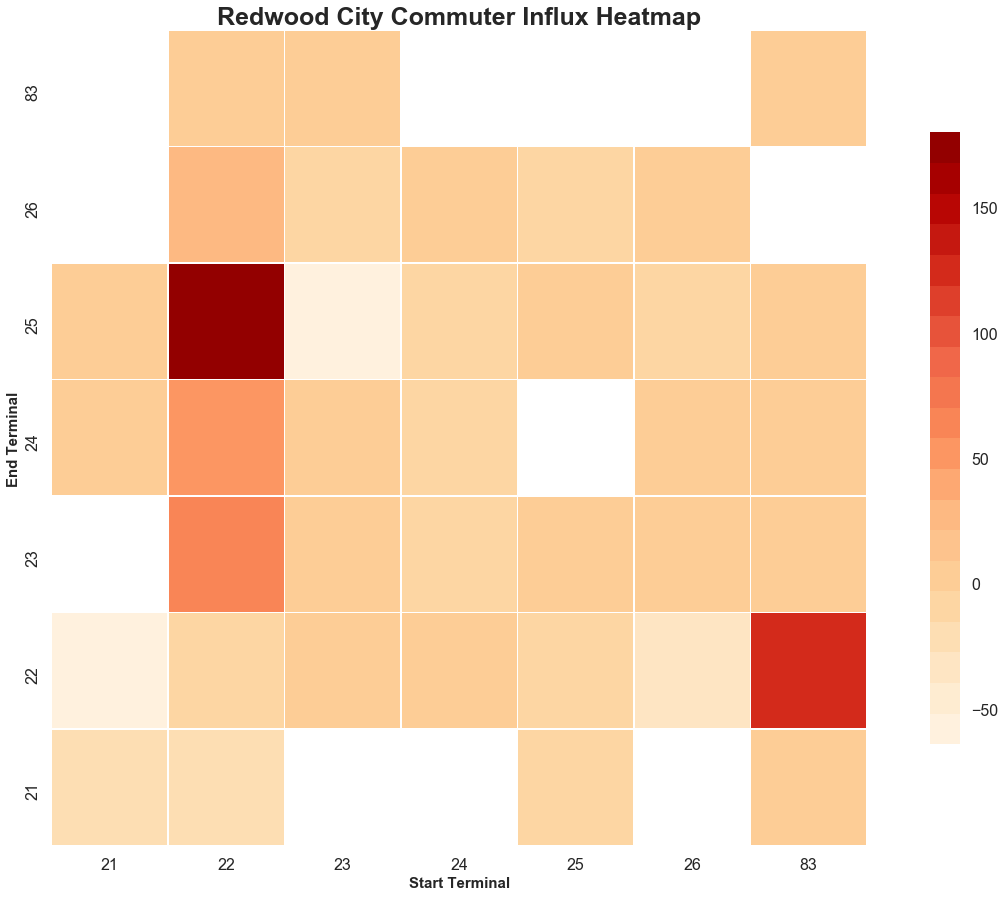

In [38]:
for zip_code in ordered_zipcodes:

    # make morning commute start -> end grid
    df = morning_commuter_trips_df[(morning_commuter_trips_df.start_zip == zip_code) & (morning_commuter_trips_df.end_zip == zip_code)].copy()

    # make empty grid of start stations on x axis, and end stations on y axis
    start_stations = sorted(pd.unique(df.start_terminal))
    end_stations = sorted(pd.unique(df.end_terminal))
    stations = start_stations

    for s in end_stations:
        if s not in stations:
            stations.append(s)

    index   = [x for x in stations]
    columns = [x for x in stations]

    trip_grid = pd.DataFrame(index=index, columns=columns)

    
    # fill in grid with count of trips from start to end terminal
    for sid in stations:
        for eid in stations:
            # count trips with each route
            route_trip_count = df[(df.start_terminal == sid) & (df.end_terminal == eid)].shape[0]
            trip_grid.loc[eid, sid] = route_trip_count

    # invert the index, more readable grid
    trip_grid = trip_grid.iloc[::-1]

    morning_commute_into_city_grid = trip_grid.copy()
    
    
    # make evening commute start -> end grid
    df = evening_commuter_trips_df[(evening_commuter_trips_df.start_zip == zip_code) & (evening_commuter_trips_df.end_zip == zip_code)].copy()

    # make empty grid of start stations on x axis, and end stations on y axis
    start_stations = sorted(pd.unique(df.start_terminal))
    end_stations = sorted(pd.unique(df.end_terminal))
    stations = start_stations
    
    for s in end_stations:
        if s not in stations:
            stations.append(s)

    index   = [x for x in stations]
    columns = [x for x in stations]

    trip_grid = pd.DataFrame(index=index, columns=columns)

    
    # fill in grid with count of trips from start to end terminal
    for sid in stations:
        for eid in stations:
            # count trips with each route
            route_trip_count = df[(df.start_terminal == sid) & (df.end_terminal == eid)].shape[0]
            trip_grid.loc[sid, eid] = route_trip_count

    # invert the index, more readable grid
    trip_grid = trip_grid.iloc[::-1]

    evening_commute_out_of_city_grid = trip_grid.copy()
    
    diff_grid = morning_commute_into_city_grid - evening_commute_out_of_city_grid
    
    diff_grid.dropna(axis=0, how='all', inplace=True)
    diff_grid.dropna(axis=1, how='all', inplace=True)
    
    # print total number of trips into the city - total number of trips out of the city
    influx_count = diff_grid.sum().sum()    
    if influx_count > 0:
        print('%s more Commuters are arriving in %s in the morning than are departing in the afternoon' % (str(abs(influx_count)).rjust(6), zip_to_landmark(zip_code)))
    else:
        print('%s fewer Commuters are arriving in %s in the morning than are departing in the afternoon' % (str(abs(influx_count)).rjust(6), zip_to_landmark(zip_code)))

    # normalize trip grid    
#     diff_grid = (diff_grid - diff_grid.mean().mean()) / (diff_grid.max().max() - diff_grid.min().min())

    mask = diff_grid == 0
#     print(diff_grid)
    grid_dims = 15
    fig, ax = plt.subplots(figsize=(grid_dims*1.5, grid_dims))

    sns.heatmap(data=diff_grid, linewidths=.5, square=True, cmap=sns.color_palette("OrRd", 20), mask=mask, ax=ax, cbar_kws={"shrink": .75}, cbar=True)

    ax.set_xlabel('Start Terminal', size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel('End Terminal', size=LABEL_FONT_SIZE, weight='bold')

    title = '%s Commuter Influx Heatmap' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)

    plt.show()

# Station Utilization at Stations 69 and 70

In [44]:
stations_of_interest=[69, 70]

station6970_trips = commuter_trips_df[(commuter_trips_df.start_terminal.isin(stations_of_interest)) | (commuter_trips_df.end_terminal.isin(stations_of_interest))]
station6970_trips.reset_index(inplace=True, drop=True)
station6970_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195405 entries, 0 to 195404
Data columns (total 23 columns):
trip_id               195405 non-null int64
duration              195405 non-null int64
start_date            195405 non-null datetime64[ns]
start_station_name    195405 non-null object
start_terminal        195405 non-null int64
end_date              195405 non-null datetime64[ns]
end_station_name      195405 non-null object
end_terminal          195405 non-null int64
bike_id               195405 non-null int64
user_type             195405 non-null category
user_zip              195405 non-null int64
duration_minutes      195405 non-null float64
start_zip             195405 non-null int64
end_zip               195405 non-null int64
max_temp              195405 non-null float64
mean_temp             195405 non-null float64
min_temp              195405 non-null float64
max_wind              195405 non-null float64
mean_wind             195405 non-null float64
max_gust          

In [56]:
trips_to_interest = station6970_trips[station6970_trips.end_terminal.isin(stations_of_interest)]
print('trips_to_interest:\t%s' % (trips_to_interest.shape[0]))

trips_from_interest = station6970_trips[station6970_trips.start_terminal.isin(stations_of_interest)]
print('trips_from_interest:\t %s' % (trips_from_interest.shape[0]))

trips_to_interest:	105601
trips_from_interest:	 90221


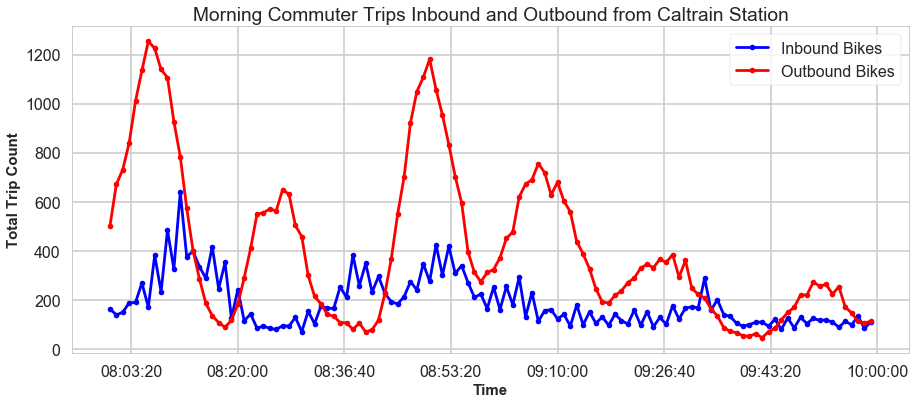

In [231]:
commute_start_hour = 8
commute_end_hour = 10

# plot trips ending at caltrian station 69 or 70, these are riders commuting out of the city
morning_region_outbound_commuters = trips_to_interest[(trips_to_interest.end_date.dt.hour < commute_end_hour) & (trips_to_interest.end_date.dt.hour >= commute_start_hour)].groupby([trips_to_interest[(trips_to_interest.end_date.dt.hour < commute_end_hour) & (trips_to_interest.end_date.dt.hour >= commute_start_hour)].end_date.dt.time])['trip_id'].count()
ax = morning_region_outbound_commuters.plot(color='b', marker='.', linestyle='-', figsize=(15,6), label='Inbound Bikes')

# plot trips starting at caltrian station 69 or 70, these are riders commuting into the city
morning_region_inbound_commuters = trips_from_interest[(trips_from_interest.start_date.dt.hour < commute_end_hour) & (trips_from_interest.start_date.dt.hour >= commute_start_hour)].groupby([trips_from_interest[(trips_from_interest.start_date.dt.hour < commute_end_hour) & (trips_from_interest.start_date.dt.hour >= commute_start_hour)].start_date.dt.time])['trip_id'].count()
morning_region_inbound_commuters.plot(color='r', marker='.', linestyle='-', ax=ax, label='Outbound Bikes')

ax.set_xlabel('Time', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Total Trip Count', size=LABEL_FONT_SIZE, weight='bold')

title = 'Morning Commuter Trips Inbound and Outbound from Caltrain Station'
ax.set_title(title)
ax.legend(loc=1, frameon=True)

image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
plt.savefig(image_title)

plt.show()


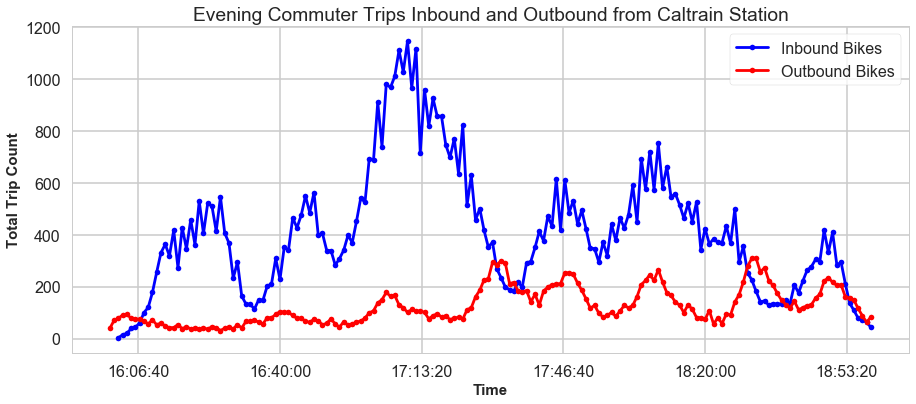

In [233]:
commute_start_hour = 16
commute_end_hour = 19

# plot trips ending at caltrian station 69 or 70, these are riders commuting out of the city
evening_region_outbound_commuters = trips_to_interest[(trips_to_interest.end_date.dt.hour < commute_end_hour) & (trips_to_interest.end_date.dt.hour >= commute_start_hour)].groupby([trips_to_interest[(trips_to_interest.end_date.dt.hour < commute_end_hour) & (trips_to_interest.end_date.dt.hour >= commute_start_hour)].end_date.dt.time])['trip_id'].count()
ax = evening_region_outbound_commuters.plot(color='b', marker='.', linestyle='-', figsize=(15,6), label='Inbound Bikes')

# plot trips starting at caltrian station 69 or 70, these are riders commuting into the city
evening_region_inbound_commuters = trips_from_interest[(trips_from_interest.start_date.dt.hour < commute_end_hour) & (trips_from_interest.start_date.dt.hour >= commute_start_hour)].groupby([trips_from_interest[(trips_from_interest.start_date.dt.hour < commute_end_hour) & (trips_from_interest.start_date.dt.hour >= commute_start_hour)].start_date.dt.time])['trip_id'].count()
evening_region_inbound_commuters.plot(color='r', marker='.', linestyle='-', ax=ax, label='Outbound Bikes')

ax.set_xlabel('Time', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Total Trip Count', size=LABEL_FONT_SIZE, weight='bold')

title = 'Evening Commuter Trips Inbound and Outbound from Caltrain Station'
ax.set_title(title)
ax.legend(loc=1, frameon=True)

image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
plt.savefig(image_title)

plt.show()


[Subscriber, Customer]
Categories (2, object): [Subscriber, Customer]

In [320]:
caltrain_station_trips = trips_df[(trips_df.start_terminal.isin(stations_of_interest)) | (trips_df.end_terminal.isin(stations_of_interest))].copy()
caltrain_station_trips.reset_index(inplace=True, drop=True)
caltrain_station_trips.head()

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,end_zip,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
0,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
1,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
2,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
3,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
4,4080,764,2013-08-29 09:36:00,South Van Ness at Market,66,2013-08-29 09:49:00,San Francisco Caltrain 2 (330 Townsend),69,315,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN


In [321]:
pd.unique(caltrain_station_trips.end_date.dt.dayofweek)

array([3, 4, 5, 6, 0, 1, 2])

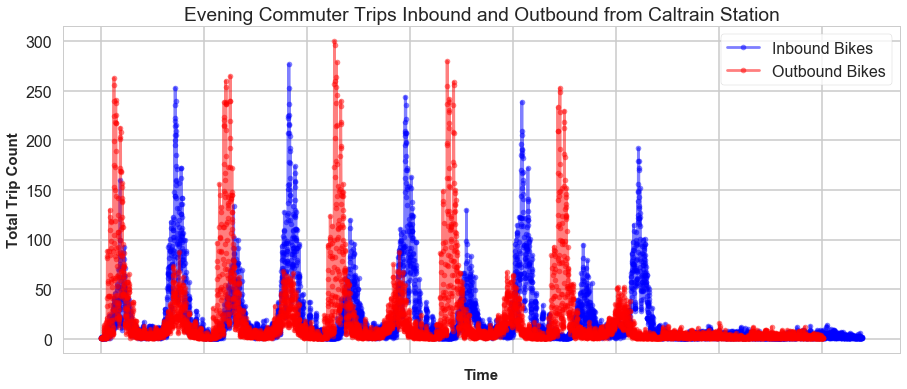

In [340]:

caltrain_station_trips = caltrain_station_trips[(caltrain_station_trips.user_type == 'Subscriber')]
# caltrain_station_trips = caltrain_station_trips[(caltrain_station_trips.start_date.dt.dayofweek < 5) & (caltrain_station_trips.end_date.dt.dayofweek < 5)]

trips_to_caltrain   = caltrain_station_trips[caltrain_station_trips.end_terminal.isin(stations_of_interest)]
trips_from_caltrain = caltrain_station_trips[caltrain_station_trips.start_terminal.isin(stations_of_interest)]

# plot trips ending at caltrian station 69 or 70, these are riders commuting out of the city
trips_to_caltrain_station = trips_to_caltrain.groupby([trips_to_caltrain.end_date.dt.dayofweek, trips_to_caltrain.end_date.dt.time])['trip_id'].count()
# trips_to_caltrain_station = trips_to_caltrain.groupby(trips_to_caltrain.end_date)['trip_id'].count()
ax = trips_to_caltrain_station.plot(alpha=0.5, color='b', marker='.', linestyle='-', figsize=(15,6), label='Inbound Bikes')

# plot trips starting at caltrian station 69 or 70, these are riders commuting into the city
trips_from_caltrain_station = trips_from_caltrain.groupby([trips_from_caltrain.start_date.dt.dayofweek, trips_from_caltrain.start_date.dt.time])['trip_id'].count()
# trips_from_caltrain_station = trips_from_caltrain.groupby(trips_from_caltrain.start_date)['trip_id'].count()
trips_from_caltrain_station.plot(alpha=0.5, color='r', marker='.', linestyle='-', ax=ax, label='Outbound Bikes')

ax.set_xlabel('Time', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Total Trip Count', size=LABEL_FONT_SIZE, weight='bold')

title = 'Evening Commuter Trips Inbound and Outbound from Caltrain Station'
ax.set_title(title)
ax.legend(loc=1, frameon=True)

# image_title = '../charts/investigation_stations/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
# plt.savefig(image_title)

plt.show()



In [341]:
# trips_to_caltrain_station

In [398]:
caltrain_trip_counts = pd.DataFrame()

caltrain_trip_counts['trips_to'] = trips_to_caltrain_station
caltrain_trip_counts['trips_from'] = trips_from_caltrain_station

caltrain_trip_counts.fillna(0, inplace=True)

# trips in - trips from
caltrain_trip_counts['net_trips'] = caltrain_trip_counts['trips_to'] - caltrain_trip_counts['trips_from']
caltrain_trip_counts['cum_net_trips'] = caltrain_trip_counts['net_trips'].cumsum()

ax = caltrain_trip_counts[['trips_to', 'trips_from']].cumsum().plot(figsize=(25,6), marker='.')

ax.set_title('title')
ax.set_ylabel('ylabel')
ax.set_xlabel('xlabel')

ymax = caltrain_trip_counts[['trips_to', 'trips_from']].cumsum().max().max()

y_interval = 10000

ymax = math.ceil(ymax/y_interval) * y_interval

ax.set_yticks([x*y_interval for x in range(0, math.ceil((y_max+y_interval)/y_interval)))])
# ax.set_yticklabels()


plt.legend(loc=4, frameon=True)

plt.show()



SyntaxError: invalid syntax (<ipython-input-398-12f9a6fa8ef6>, line 24)

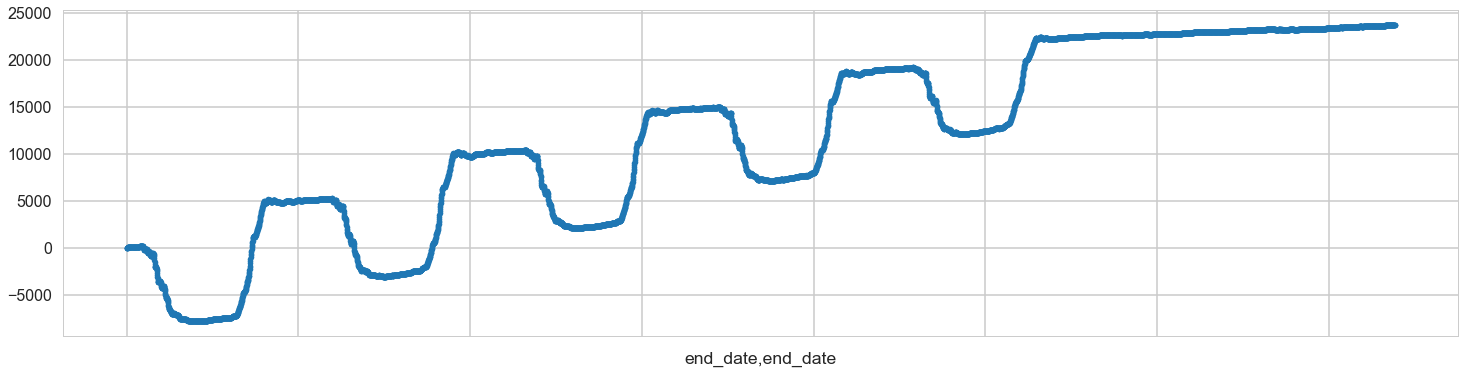

In [385]:
caltrain_trip_counts['cum_net_trips'].plot(figsize=(25,6), marker='.')
plt.show()